# Business Objective

<div style="text-align: justify;">

Banks are obligated to manage their risk when it comes to giving loans reactively and proactively. In order to achieve this, various methods of calculating defaults have been developed over the years. This notebook demonstrates how a bank could potentially segment its clients with the aim of creating Machine Learning Credit Scoring models as needed. The idea is a model trained on specific population performs better than a single one trained on the entire population.

</div>

<div style="text-align: justify;">

Based on the previous statement, four questions are formulated:

* What features are we going to use to split our population?
* How are we going to split our population?
* How many clusters are we supposed to aim in order to make the evaluation sustainable?
* How do granular models perform better than a single one?
* What added value does having more than a model provide to the business? In case granular models beat the single one.

</div>


# Notebook Initialization

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import warnings

from itertools import combinations as combi
from libs.visualization import bcolors
from libs.modellingFunx import BusinessDecisionTreeClassifier, FixedBusinessDecisionTreeClassifier
from umap import UMAP
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier, export_text

# libraries configuration
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

Reading dataframe and getting initial information

In [2]:
# getting data from csv file
data = pd.read_csv('datasets/Base_SolicitudesCreditoEfectivo_201307_201505.csv', sep = ";")

# showing top 5
data.head()

CODMES  CODSOLICITUD         DEUDA  PLAZO_CREDITO  FLG_GARANTIA  \
0  201402             1   7116.681318             48             0   
1  201404             2   1616.555000             60             0   
2  201403             3   8082.775000             48             0   
3  201307             4  10186.990760             48             0   
4  201401             5  10777.033330             48             0   

   MIN_MES_DE_DEFAULT  FLG_DEFAULT_12M           SEGMENTOCLIENTE  \
0                 NaN                0              CLIENTES ORO   
1                 NaN                0              CLIENTES ORO   
2                 NaN                0              CLIENTES ORO   
3            201403.0                1              CLIENTES ORO   
4                 NaN                0  CLIENTES PLATINUM SEGM 2   

   TARJETA_RELACIONADA  VEHICULAR_RELACIONADA  HIPOTECARIO_RELACIONADA  \
0                    1                      0                        0   
1                    1                      0                        0   
2                    1                      0                        0   
3                    0                      0                        0   
4                    1                      0                        0   

   ATRASO_MAXIMO_ULT_6M  ATRASO_MAXIMO_ULT_12M  ATRASO_MAXIMO_ULT_24M  \
0                     0                    0.0                    0.0   
1                     0                    0.0                    0.0   
2                     0                    0.0                    0.0   
3                     0                    0.0                    0.0   
4                     0                    0.0                    0.0   

   MESES_AHORROS_ULT_6M  MEDIANA_AHORROS_ULT_6M  DEUDA_TOTAL_SISTEMA  \
0                   6.0             3772.486272              5450.35   
1                   6.0             8389.745000                 0.00   
2                   6.0             1842.695000                 0.00   
3                   6.0             4514.070000              5661.25   
4                   6.0             7848.908333                 0.00   

   CLASIF_SISTEMA_ULT_12M  FLG_PDH  NUMERO_DE_PAGOS_PDH  MONTO_TC_SISTEMA  \
0                     0.0        1                   24           4067.03   
1                     0.0        1                   24              0.00   
2                     0.0        1                   13              0.00   
3                     0.0        1                   24              0.00   
4                     0.0        1                    6              0.00   

   INGRESO_CLIENTE                PROFESION ZONA_DEL_DESEMBOLSO ESTADO_CIVIL  \
0      2526.246600                INGENIERO             UCAYALI          SOL   
1      2895.761372                  TECNICO            AREQUIPA          CAS   
2      1474.419056       INGENIERO DE MINAS                PUNO          SOL   
3      1992.756892                  TECNICO               CUZCO          SOL   
4      1680.938223  TEC MECANICO AUTOMOTRIZ           LIMA_ESTE          CAS   

   EDAD_T       CUOTA  LINEA_DE_TC  MONTO_TC_MEMBRESIA  FLG_TC_VISA  FLG_TC_MC  
0    26.0  236.983971       5600.0               170.0          0.0        0.0  
1    49.0   62.089650      19250.0               170.0          0.0        0.0  
2    33.0   22.894893      10900.0                80.0          0.0        0.0  
3    25.0  244.267800      10900.0                80.0          0.0        0.0  
4    57.0   17.430000      16300.0               170.0          0.0        0.0

# <span style="color:#FF6600; font-weight:bold;">First Question:</span> <span style="color:#6699CC;">What features are we going to use to split our population?</span>


To start with, the business needs to have the capability of quantify its cutoffs so that it can manage its features properly. To sum up, it is important to determine how many variables are numeric and which of these are useful for generating intervals. This leads to the following question: 

<span style="color:#B0E57C; font-weight:bold;">01. What numeric features are relevant for splitting our universe?</span>

In order to answer the question, let's get the numeric features as first step.

In [3]:
# showing only numeric features based on their dtypes
num_data = data.select_dtypes(include = np.number)

# displaying numeric features
display(num_data.head())

CODMES  CODSOLICITUD         DEUDA  PLAZO_CREDITO  FLG_GARANTIA  \
0  201402             1   7116.681318             48             0   
1  201404             2   1616.555000             60             0   
2  201403             3   8082.775000             48             0   
3  201307             4  10186.990760             48             0   
4  201401             5  10777.033330             48             0   

   MIN_MES_DE_DEFAULT  FLG_DEFAULT_12M  TARJETA_RELACIONADA  \
0                 NaN                0                    1   
1                 NaN                0                    1   
2                 NaN                0                    1   
3            201403.0                1                    0   
4                 NaN                0                    1   

   VEHICULAR_RELACIONADA  HIPOTECARIO_RELACIONADA  ATRASO_MAXIMO_ULT_6M  \
0                      0                        0                     0   
1                      0                        0                     0   
2                      0                        0                     0   
3                      0                        0                     0   
4                      0                        0                     0   

   ATRASO_MAXIMO_ULT_12M  ATRASO_MAXIMO_ULT_24M  MESES_AHORROS_ULT_6M  \
0                    0.0                    0.0                   6.0   
1                    0.0                    0.0                   6.0   
2                    0.0                    0.0                   6.0   
3                    0.0                    0.0                   6.0   
4                    0.0                    0.0                   6.0   

   MEDIANA_AHORROS_ULT_6M  DEUDA_TOTAL_SISTEMA  CLASIF_SISTEMA_ULT_12M  \
0             3772.486272              5450.35                     0.0   
1             8389.745000                 0.00                     0.0   
2             1842.695000                 0.00                     0.0   
3             4514.070000              5661.25                     0.0   
4             7848.908333                 0.00                     0.0   

   FLG_PDH  NUMERO_DE_PAGOS_PDH  MONTO_TC_SISTEMA  INGRESO_CLIENTE  EDAD_T  \
0        1                   24           4067.03      2526.246600    26.0   
1        1                   24              0.00      2895.761372    49.0   
2        1                   13              0.00      1474.419056    33.0   
3        1                   24              0.00      1992.756892    25.0   
4        1                    6              0.00      1680.938223    57.0   

        CUOTA  LINEA_DE_TC  MONTO_TC_MEMBRESIA  FLG_TC_VISA  FLG_TC_MC  
0  236.983971       5600.0               170.0          0.0        0.0  
1   62.089650      19250.0               170.0          0.0        0.0  
2   22.894893      10900.0                80.0          0.0        0.0  
3  244.267800      10900.0                80.0          0.0        0.0  
4   17.430000      16300.0               170.0          0.0        0.0

As we need features that represent the client's level of indebtedness, their liabilities, and their income, we select "DEUDA", "MEDIANA_AHORROS_ULT_6M" and "INGRESO_CLIENTE". We need to check their distribution to choose proper intervals.

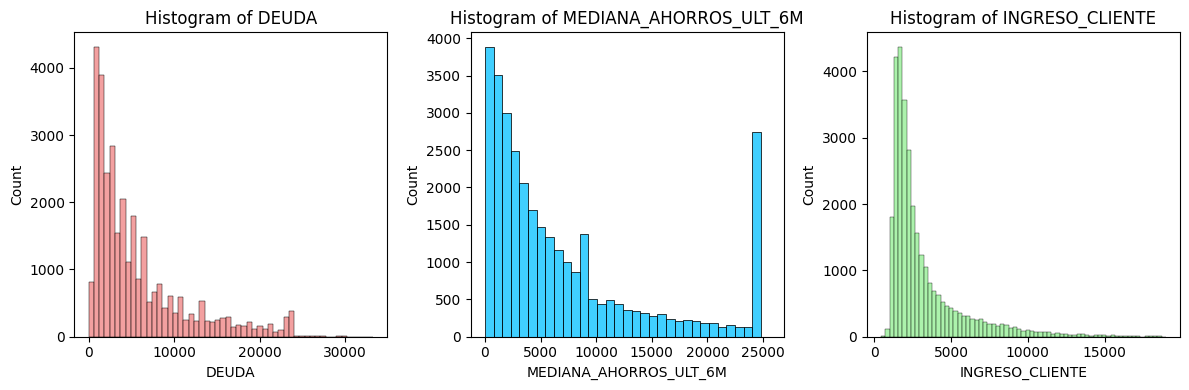

In [4]:
# declaring features to evaluate
selected_numeric_features = ['DEUDA', 'MEDIANA_AHORROS_ULT_6M', 'INGRESO_CLIENTE']

# creating colors
colors = ['lightcoral', 'deepskyblue', 'lightgreen']
# declaring fig and axis
fig, axis = plt.subplots(1, 3, figsize = (12, 4))

# iterating along selected features
for n_iter, (feature, color) in enumerate(zip(selected_numeric_features, colors)):
    # chossing axis
    ax = axis[n_iter]

    # removing outliers just for visualization purposes
    temp = data.loc[(data[feature] < data[feature].quantile(0.999))]

    # getting bins
    bins = np.histogram_bin_edges(a = temp.loc[~temp[feature].isnull(), feature].to_numpy(), bins = 'scott')
    # plotting histogram
    sns.histplot(data = temp,
                 x = feature,
                 bins = bins,
                 color = color,
                 ax = ax)
    # creating titles
    ax.set_title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* The three histograms are skewed to the right, which means we have more small clients rather than big ones.
* It can be observed that the cutoffs could be two based on their frequency.
* It would be naive to decide the segments just by looking at this univariate analysis, it is mandatory to check on the RD distribution.

To arrive at a decision we should verify how much they represent in terms of their amount and N. This approach is performed by calculating their deciles.

In [5]:
# creating percentiles
for feature in selected_numeric_features:
    # creating array 
    percentiles = num_data[feature].quantile([round(num, 1) for num in np.linspace(0.1, 0.9, 9)])\
                                   .to_dict()
        
    # rounding percentiles
    percentiles = {key: round(value / 50) * 50 for key, value in percentiles.items()}

    # creating choise list
    values = list(percentiles.values())

    # creating conditions
    conditions = [num_data[feature] <= value for value in values]
    
    # adding upper bound condition
    conditions += [num_data[feature] > values[-1]]

    choice_list = [f'[0 - {values[0]:,.0f}]']
    choice_list += [f'<{values[i]:,.0f} - {values[i + 1]:,.0f}]' for i in range(len(values) - 1)]
    choice_list += [f'<{values[-1]:,.0f} - +inf>']

    # creating new dict to map
    choice_list_dict = dict(zip(choice_list, list(percentiles.keys()) + [list(percentiles.keys())[-1] + 0.01]))

    # creating columns
    num_data[f'{feature}_percen_label'] = np.select(condlist = conditions,
                                                    choicelist = choice_list,
                                                    default = choice_list[0])
    
    num_data[f'{feature}_percen_value'] = num_data[f'{feature}_percen_label'].map(choice_list_dict)

An important view to select a proper segmentation is to analyze how ratio of default changes throughout the deciles does it

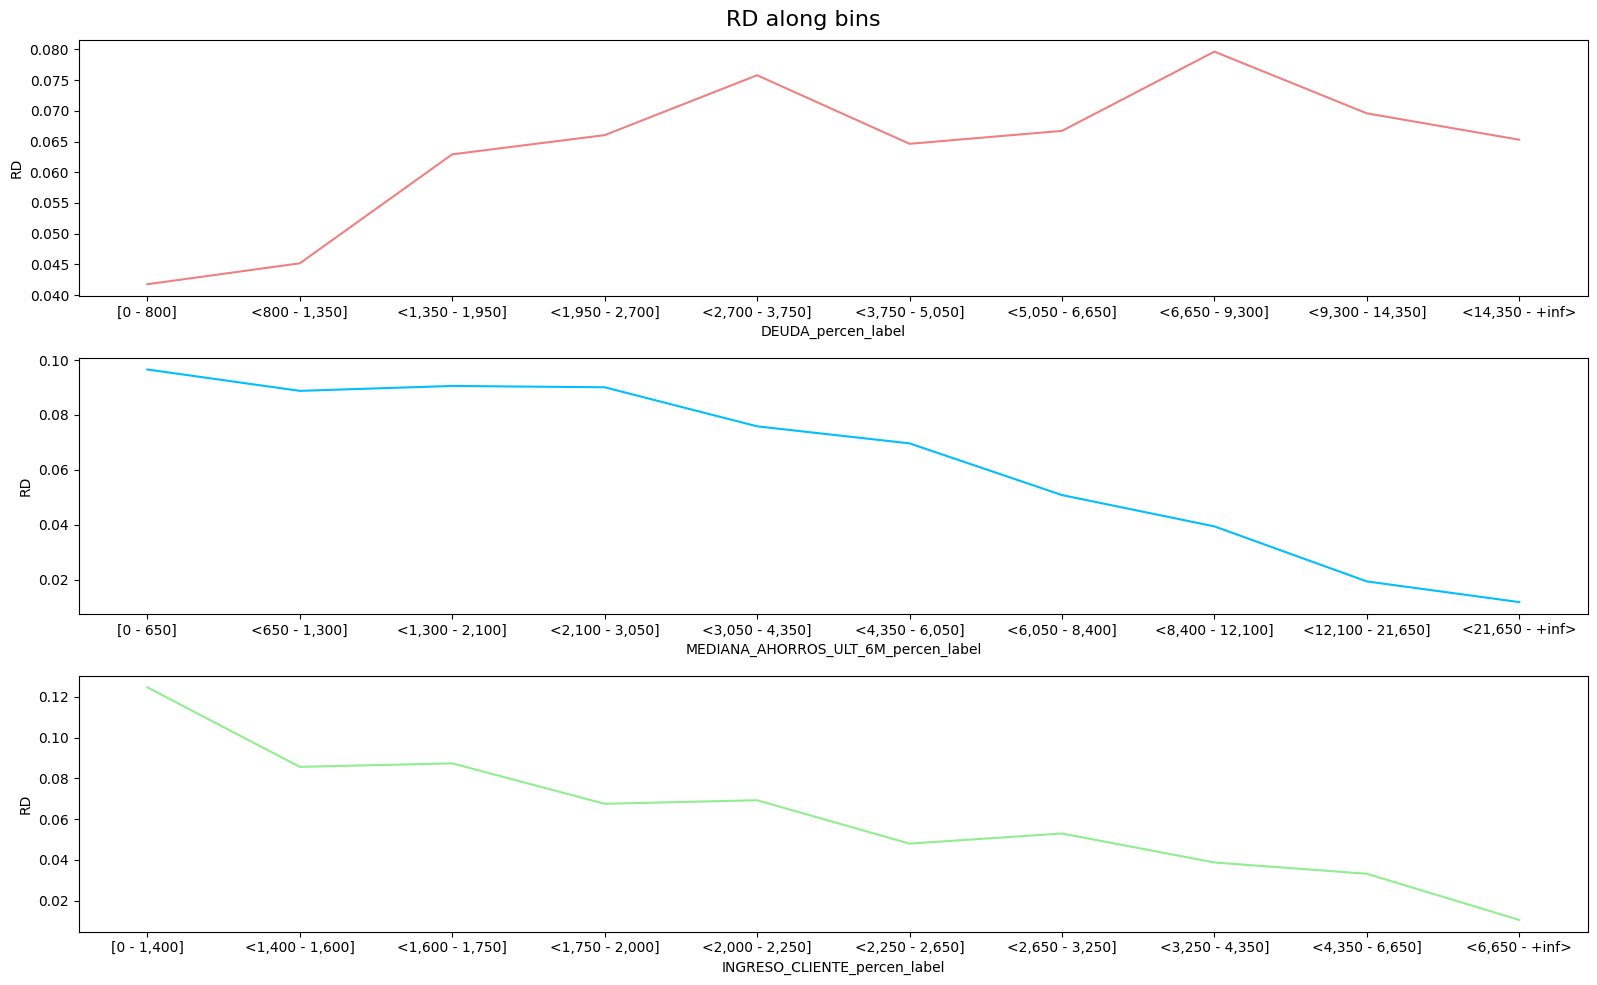

In [6]:
# declaring fig and axis
fig, axis = plt.subplots(3, 1, figsize = (16, 10))

# adding title
fig.suptitle('RD along bins', fontsize = 16)

# iterating along selected features
for n_iter, (feature, color) in enumerate(zip(selected_numeric_features, colors)):
    # selecting created features
    label = f'{feature}_percen_label'
    value = f'{feature}_percen_value'

    # getting labels
    labels = num_data[[value, label]].drop_duplicates()

    # grouping by values
    grouped = num_data.groupby(value, as_index = False)\
                      .agg({'FLG_DEFAULT_12M': 'mean'})
    
    # changing labels
    grouped = grouped.merge(right = labels,
                            on = [value],
                            how = 'left')\
                     .rename(columns = {'FLG_DEFAULT_12M': 'RD'})\
                     .drop(columns = value)
    
    # creating plot
    ax = axis[n_iter]
    sns.lineplot(data = grouped, x = label, y = 'RD', ax = ax, color = color)

    # changing axis
    ax.set_xticks(range(len(grouped[label])), grouped[label].tolist())
    ax.set_xticklabels(grouped[label].tolist(), rotation = 0)

plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* The RD changes properly according to their nested features inasmuch as debt, liabilities and credits are behaving correctly.
* It is observed that whereas clients have more income and saved money their probability of default decreases.
* Since the selected features make economic sense as expected, we can begin our segmentation by splitting the population using those features.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

The chosen features could be Debt, Liabilities and Incomes.

As it can be seen, this numeric features have the economic sense since the RD is changing properly according to their definition. Nevertheless, this is an univariate analysis, we cannot assure that this behavior will be the same for the rest of the features, this comes to second question of this section:

<span style="color:#B0E57C; font-weight:bold;">02. Do these numeric features represent their inner meaning on the entire population?</span>

In order to answer this subquestion, it is important verify the RD by creating a pivot table with those features as a first step.

In [7]:
# defining a function to pivot table
def pivot_table_with_labels(data, 
                            index_value, 
                            column_value,
                            index_label,
                            column_label,
                            values, 
                            aggfunc):
    

    row_label = dict(num_data[[index_value, index_label]].drop_duplicates()\
                                                         .sort_values(by = index_value)\
                                                         .to_dict('split')['data'])

    col_label = dict(num_data[[column_value, column_label]].drop_duplicates()\
                                                           .sort_values(by = column_value)\
                                                           .to_dict('split')['data'])
    pivot = pd.pivot_table(data = data,
                           index = index_value,
                           columns = column_value,
                           values = values,
                           aggfunc = aggfunc)\
              .sort_index(ascending = False)
    
    pivot.index = pivot.index.map(row_label)
    pivot.columns = pivot.columns.map(col_label)
    return pivot

Creating heatmaps to see how RD changes

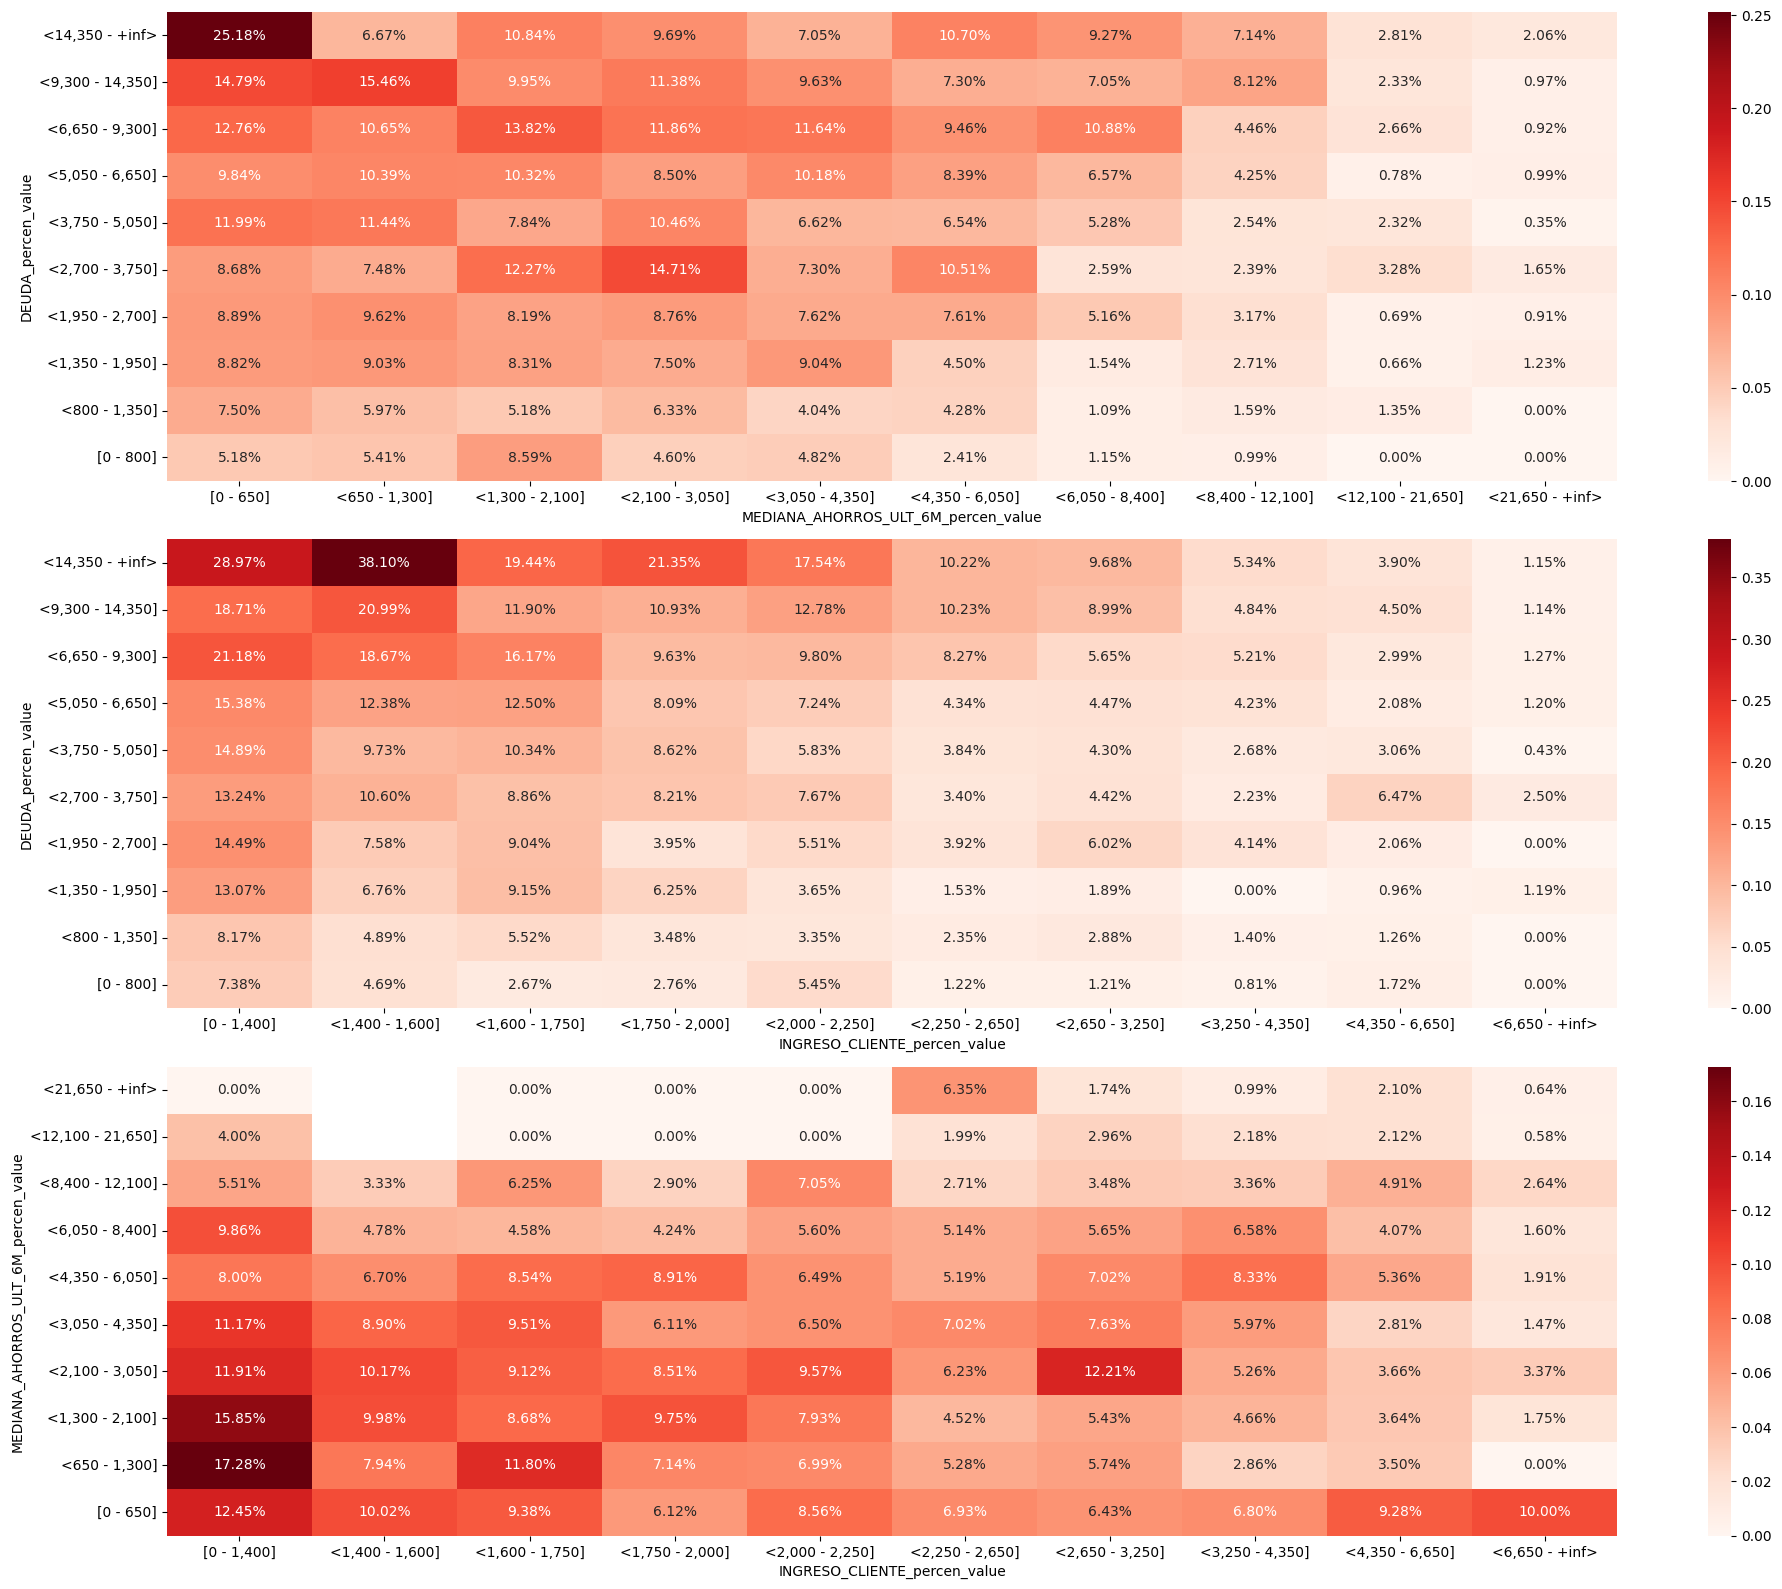

In [8]:
# creating combinations
combinations = [(selected_numeric_features[0], selected_numeric_features[1]),
                (selected_numeric_features[0], selected_numeric_features[2]),
                (selected_numeric_features[1], selected_numeric_features[2])]

# creating fig
fig, axis = plt.subplots(3, 1, figsize = (20, 16))

# iterating along combinations
for n_iter, (index, column) in enumerate(combinations):
    # creating index and columns
    index_value = f'{index}_percen_value'
    index_label = f'{index}_percen_label'
    column_value = f'{column}_percen_value'
    column_label = f'{column}_percen_label'

    # generating pivot table
    pivot = pivot_table_with_labels(data = num_data,
                                    index_value = index_value,
                                    column_value = column_value,
                                    index_label = index_label,
                                    column_label = column_label,
                                    values = 'FLG_DEFAULT_12M',
                                    aggfunc = 'mean')
    
    # creating axis
    ax = axis[n_iter]

    # generating plot
    sns.heatmap(data = pivot,
                fmt = '.2%',
                annot = True,
                cmap = 'Reds',
                ax = ax)
    # Rotating x-axis labels horizontally
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)    
    
plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* It can be appreciated that having so much debt does not necessarily mean that the risk will increase. Upon examining the first pivot table, we observe that is also connected to the client's liabilities, if they have sufficient money in their bank account they can manage to have as much debt as their risk tendency allows it.
* The previous behavior is replicated on the rest of the tables. In spite of being useful to begin segmenting, it is mandatory to analyze other aggregations and features as well.

Other important view could be the materiality of our leads we have in each cell.

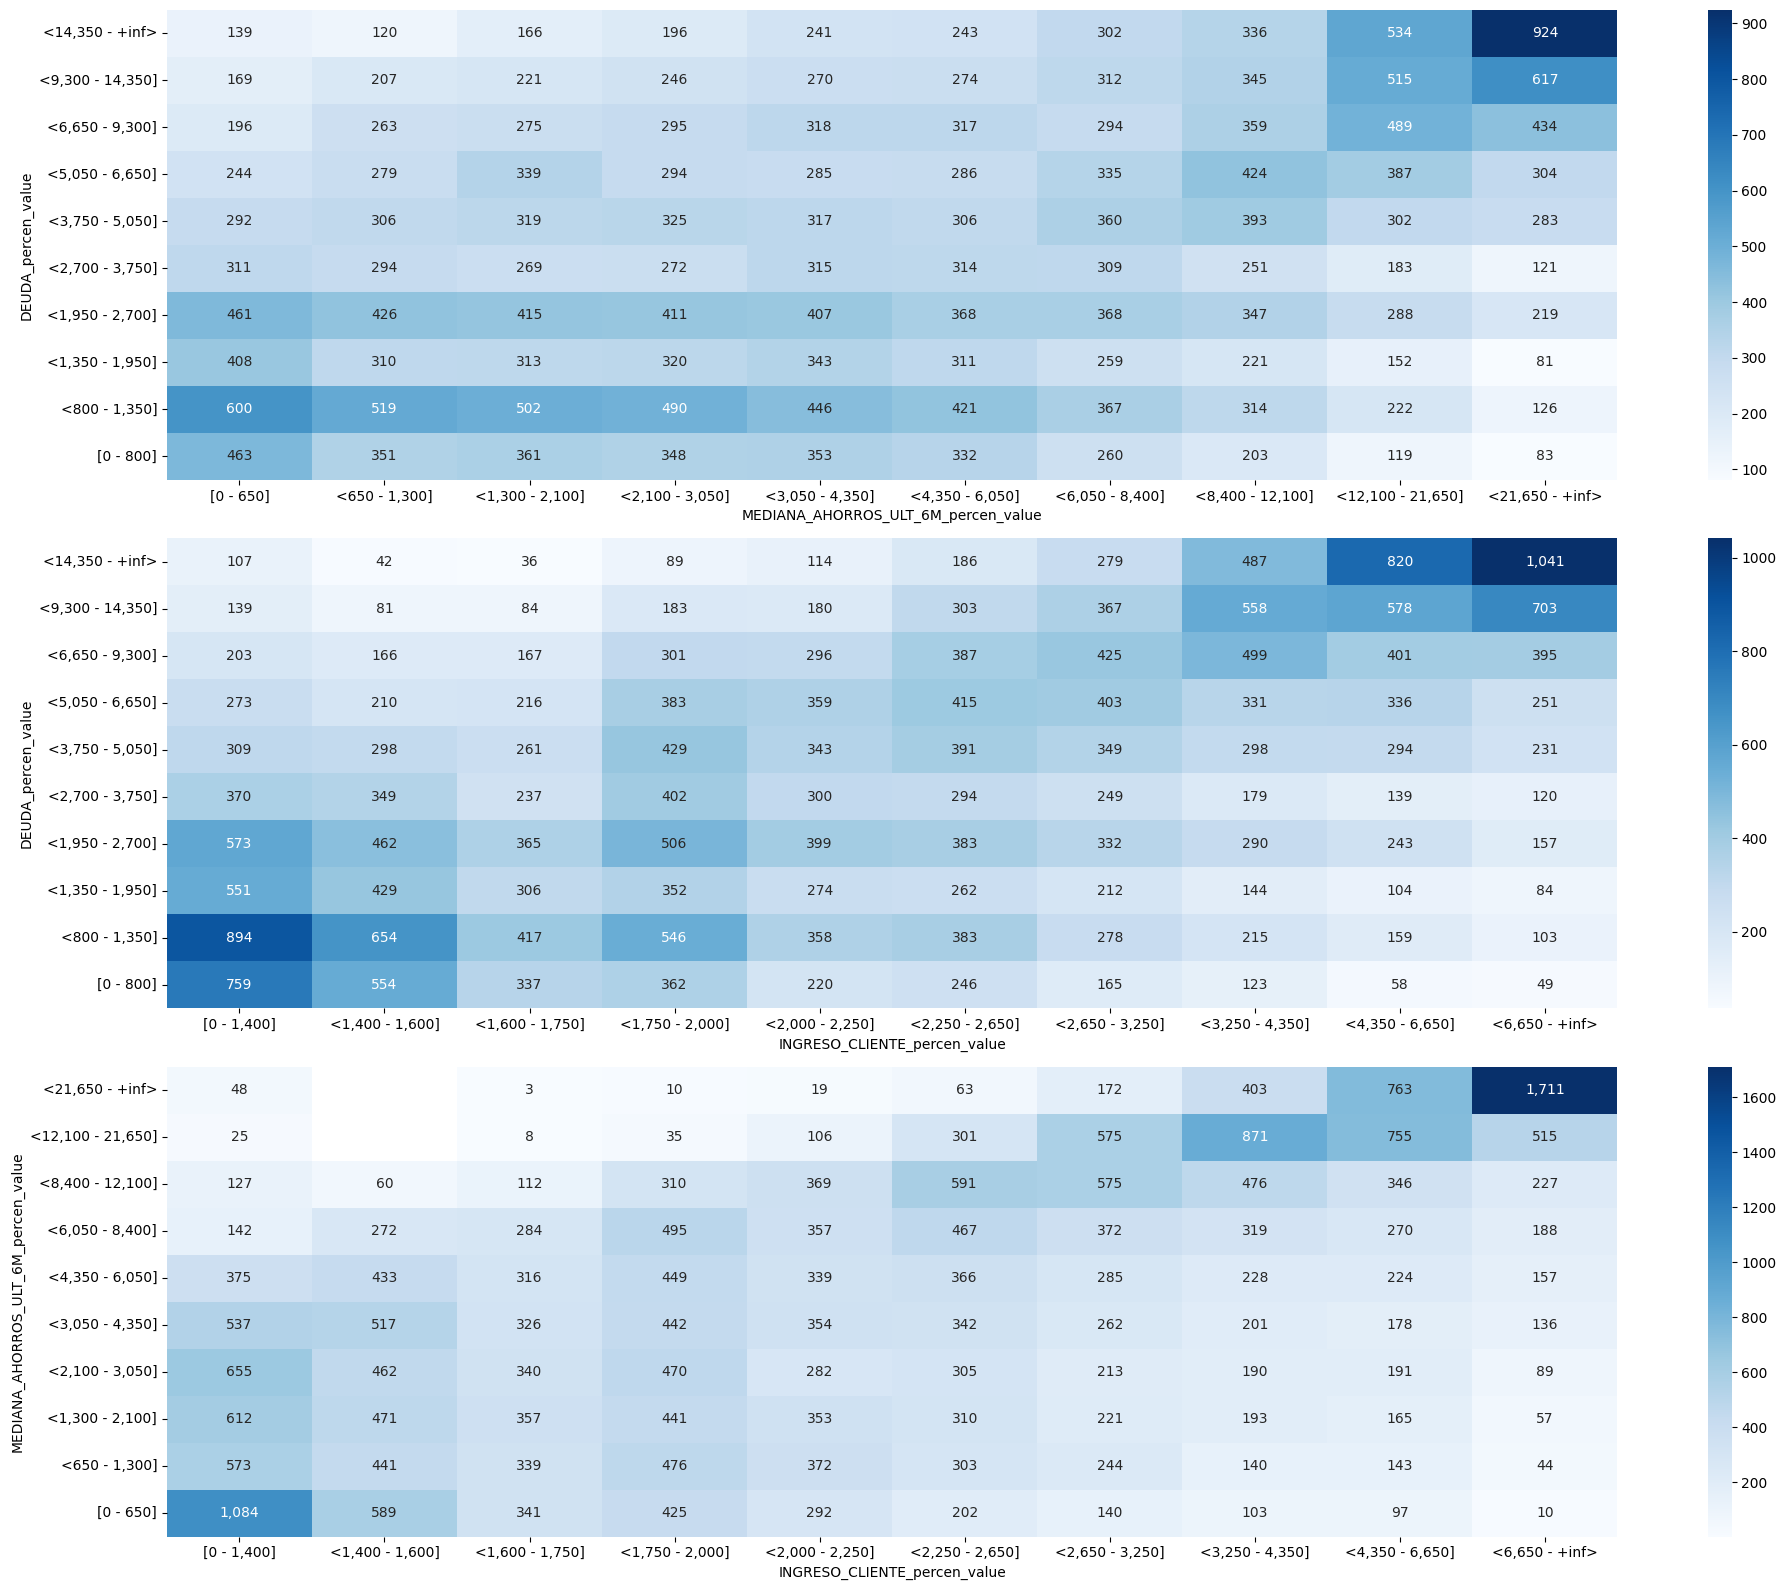

In [9]:
# creating combinations
combinations = [(selected_numeric_features[0], selected_numeric_features[1]),
                (selected_numeric_features[0], selected_numeric_features[2]),
                (selected_numeric_features[1], selected_numeric_features[2])]

# creating fig
fig, axis = plt.subplots(3, 1, figsize = (20, 16))

# iterating along combinations
for n_iter, (index, column) in enumerate(combinations):
    # creating index and columns
    index_value = f'{index}_percen_value'
    index_label = f'{index}_percen_label'
    column_value = f'{column}_percen_value'
    column_label = f'{column}_percen_label'

    # generating pivot table
    pivot = pivot_table_with_labels(data = num_data,
                                    index_value = index_value,
                                    column_value = column_value,
                                    index_label = index_label,
                                    column_label = column_label,
                                    values = 'CODSOLICITUD',
                                    aggfunc = 'count')
    
    # creating axis
    ax = axis[n_iter]

    # generating plot
    sns.heatmap(data = pivot,
                fmt = ',.0f',
                annot = True,
                cmap = 'Blues',
                ax = ax)
    # Rotating x-axis labels horizontally
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)    
    
plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* The population is well distributed, this might occur because of the decil cutoff previously performed. We have enough leads to start selecting the proper intervals.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

No, they inner meaning makes sense to their concept but they need to be treated as part of something bigger.

As it can be observed, it is not cause and effect that a single feature represents the RD behavior. Therefore, we should use other variables to determine how to split the universe. It is important to remark that a feature to segment does not have to be treated as one used to train the model, the followind would be:

<span style="color:#B0E57C; font-weight:bold;">03. What other features do we should use to segment and to aggregate?</span>

Another approach to segmentation is to create relative features, such as The Share of Wallet (Sow), which in this case would represent the proportion of the client's debt that is owed to us compared to their total debt within the financial system.

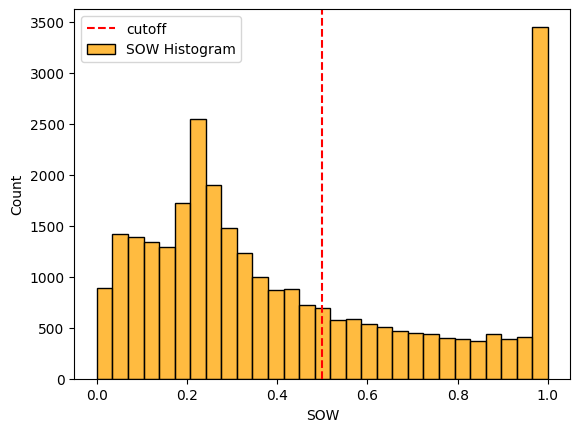

In [10]:
# create feature for SoW
num_data['SOW'] = num_data['DEUDA'] / (num_data['DEUDA'] + num_data['DEUDA_TOTAL_SISTEMA'])

# Visualize distribution
# calculate bins 
bins = np.histogram_bin_edges(a = num_data.loc[~num_data['SOW'].isnull(), 'SOW'].to_numpy(), bins = 'scott')

sns.histplot(data = num_data, x = 'SOW',bins = bins, color = 'orange', label = 'SOW Histogram')
plt.axvline(x = 0.5, ls = '--', color = 'red', label = 'cutoff')
plt.legend()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* We can create two groups by looking at the histogram. It can be seen two sides at 0.5 percentage, so there is where we leave a cutoff.

In order to validate how "SOW" ranks our target along itself and with the previously selected features, we need to cross them into a tab.

In [11]:
# create label and value
dict_sow = {'[0 - 0.5]': 0,
            '<0.5 - 1.0]': 1}

# generate features
num_data['SOW_percen_label'] = np.select(condlist = [num_data['SOW'] <= 0.5, num_data['SOW'] > 0.5],
                                         choicelist = list(dict_sow.keys()),
                                         default = list(dict_sow.keys())[0])

num_data['SOW_percen_value'] = num_data['SOW_percen_label'].map(dict_sow)

Evaluating RD with the previous features

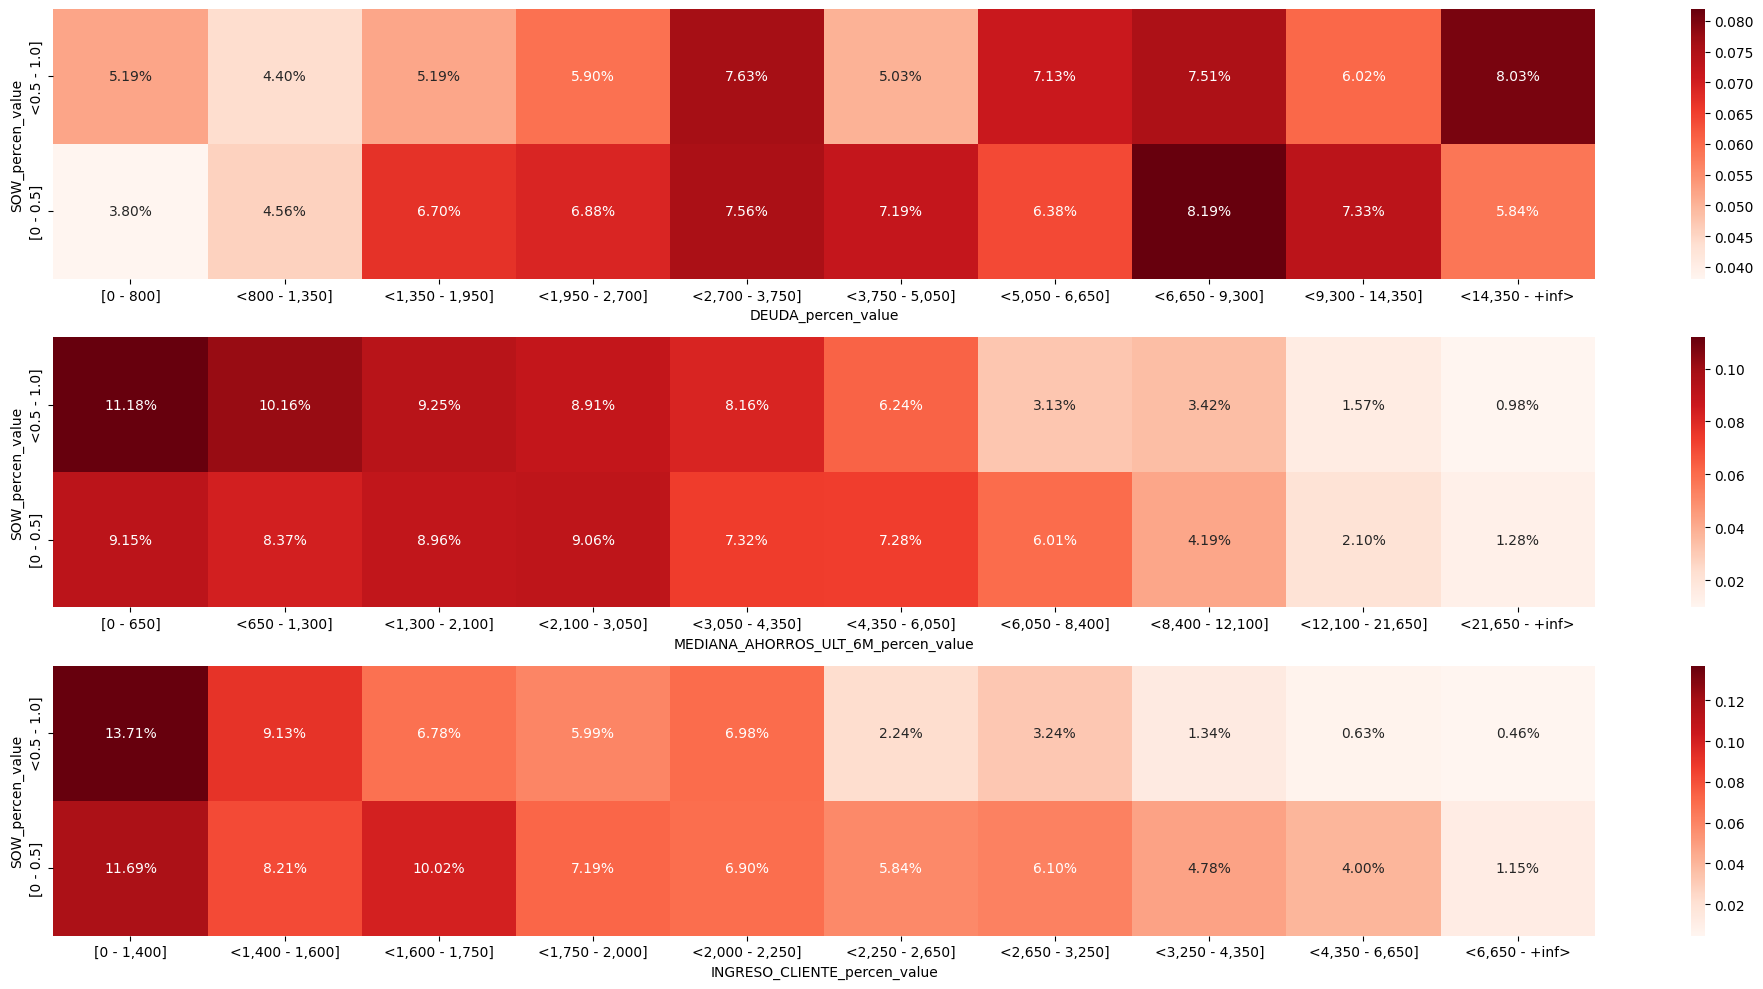

In [12]:
# creating combinations
combinations = [('SOW', selected_numeric_features[0]),
                ('SOW', selected_numeric_features[1]),
                ('SOW', selected_numeric_features[2])]

# creating fig
fig, axis = plt.subplots(3, 1, figsize = (20, 10))

# iterating along combinations
for n_iter, (index, column) in enumerate(combinations):
    # creating index and columns
    index_value = f'{index}_percen_value'
    index_label = f'{index}_percen_label'
    column_value = f'{column}_percen_value'
    column_label = f'{column}_percen_label'

    # generating pivot table
    pivot = pivot_table_with_labels(data = num_data,
                                    index_value = index_value,
                                    column_value = column_value,
                                    index_label = index_label,
                                    column_label = column_label,
                                    values = 'FLG_DEFAULT_12M',
                                    aggfunc = 'mean')
    
    # creating axis
    ax = axis[n_iter]

    # generating plot
    sns.heatmap(data = pivot,
                fmt = '.2%',
                annot = True,
                cmap = 'Reds',
                ax = ax)
    # Rotating x-axis labels horizontally
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)    
    
plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* There is no big difference between debt and liabilities, however, it is clear that this new feature sorts incomes more efficiently, therefore it should be used right after this variable.
* In terms of begin a segmentation, Debt, Liabilities, Incomes and SoW are well fitted. We should see other aggregations to continue supporting this statement.

We have 4 features to segment and 2 for aggregations so far. Now, it would be relevant to observe how old are our clients in each cell box in order to give them a loan and expect to get paid.

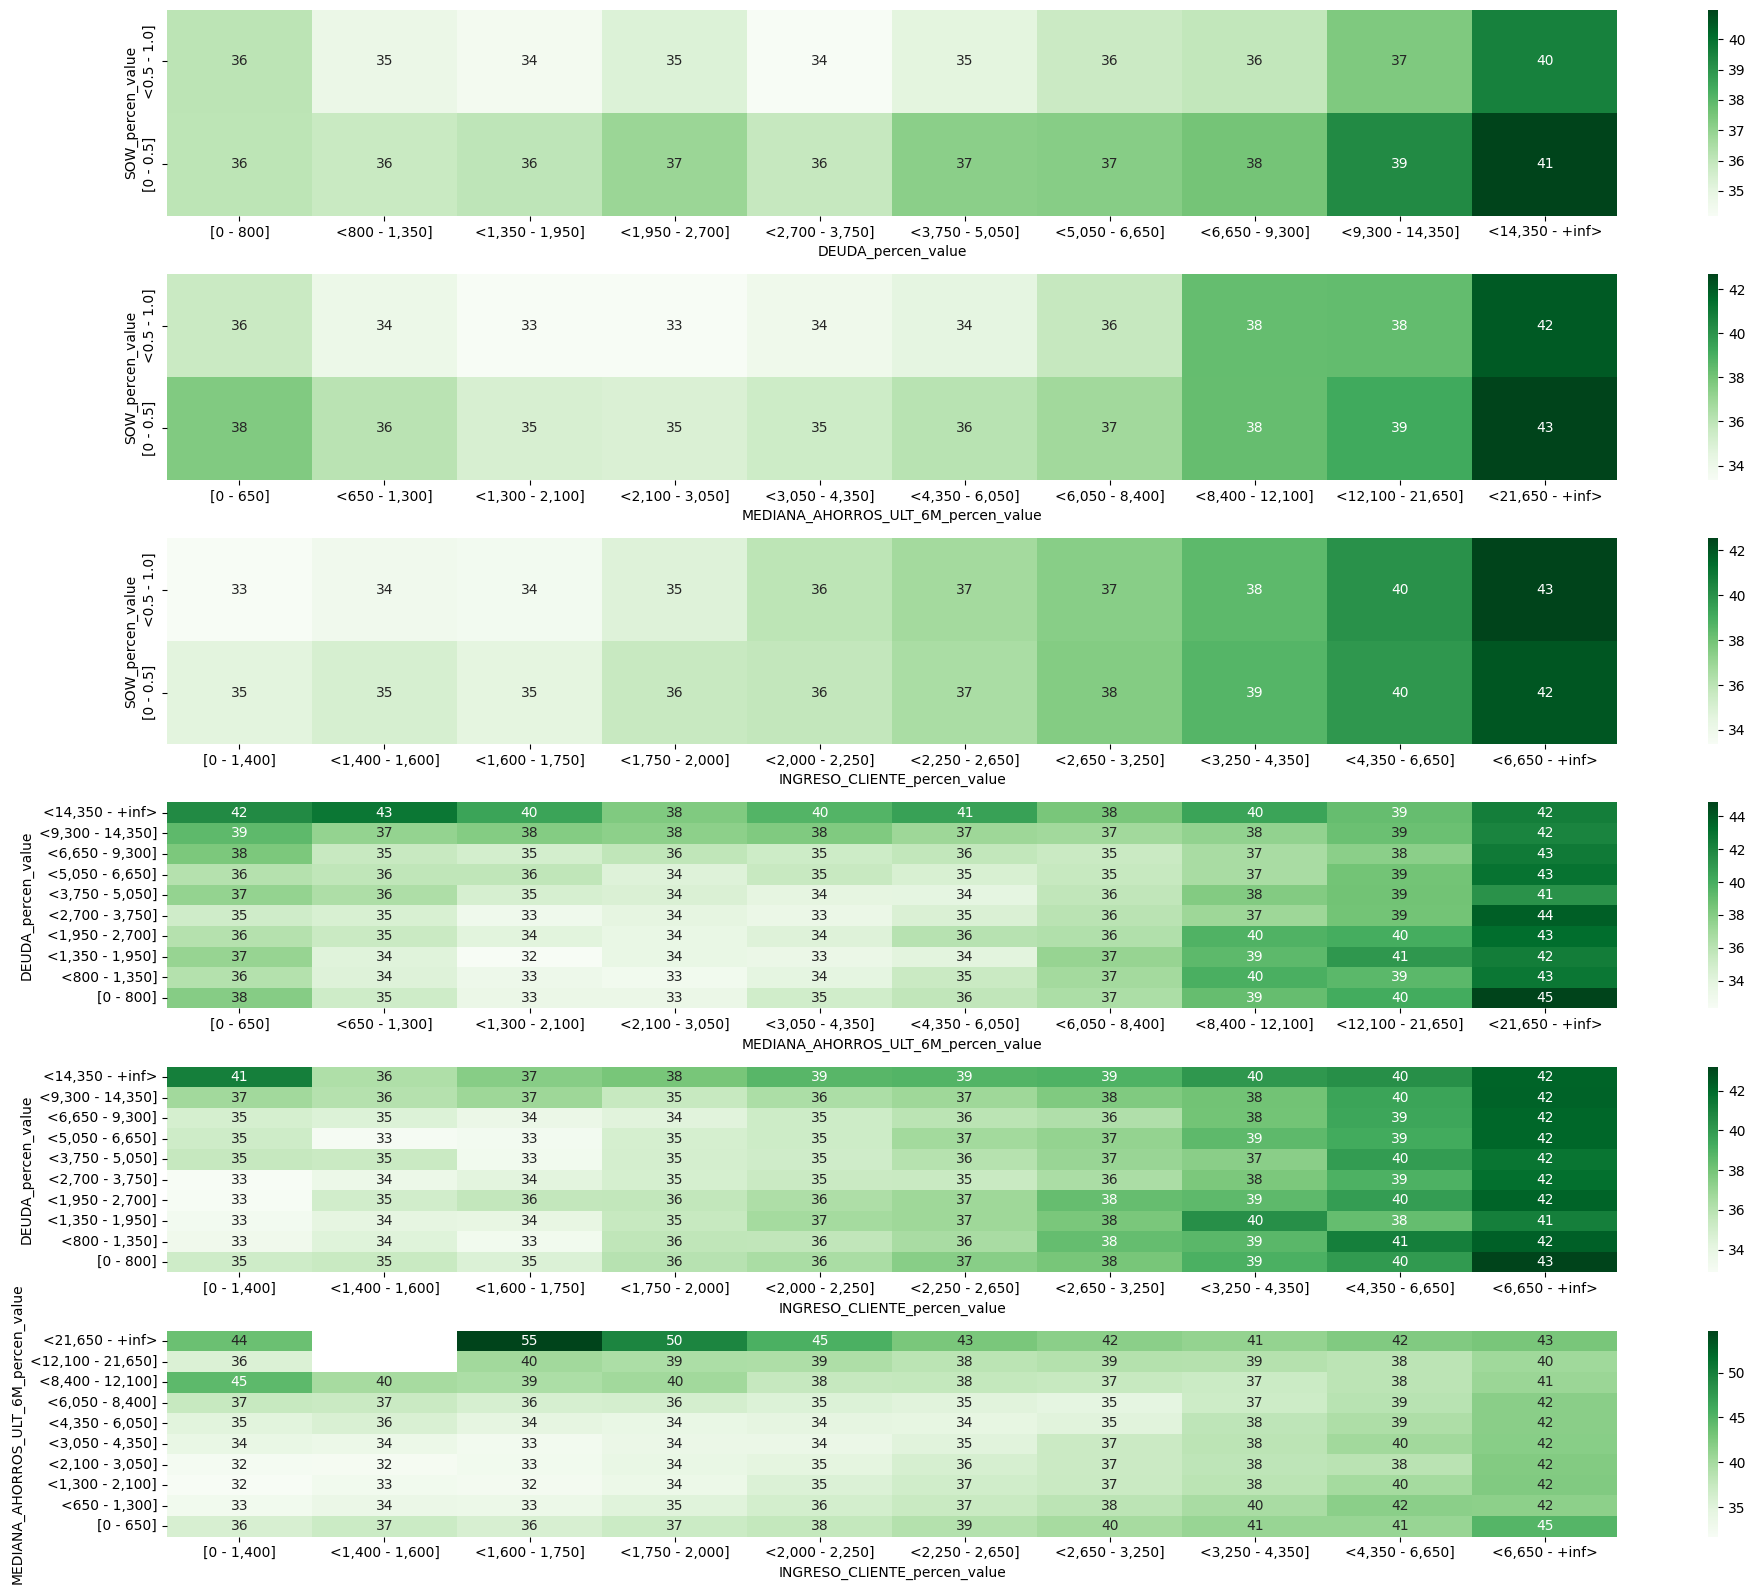

In [13]:
# creating combinations
combinations = [('SOW', selected_numeric_features[0]),
                ('SOW', selected_numeric_features[1]),
                ('SOW', selected_numeric_features[2]),
                (selected_numeric_features[0], selected_numeric_features[1]),
                (selected_numeric_features[0], selected_numeric_features[2]),
                (selected_numeric_features[1], selected_numeric_features[2])]

# creating fig
fig, axis = plt.subplots(6, 1, figsize = (20, 16))

# iterating along combinations
for n_iter, (index, column) in enumerate(combinations):
    # creating index and columns
    index_value = f'{index}_percen_value'
    index_label = f'{index}_percen_label'
    column_value = f'{column}_percen_value'
    column_label = f'{column}_percen_label'

    # generating pivot table
    pivot = pivot_table_with_labels(data = num_data,
                                    index_value = index_value,
                                    column_value = column_value,
                                    index_label = index_label,
                                    column_label = column_label,
                                    values = 'EDAD_T',
                                    aggfunc = 'mean')
    
    # creating axis
    ax = axis[n_iter]

    # generating plot
    sns.heatmap(data = pivot,
                fmt = '.0f',
                annot = True,
                cmap = 'Greens',
                ax = ax)
    # Rotating x-axis labels horizontally
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)    
    
plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* It is particulary sensible that the higher values correspond to how old the client is. This first cutoff could be done at the sixth decil.
* The ages are not separated completely, the average seems to be 33.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

The new selected feature would be the created "SOW" and the aggregation would be the age.

After analyzing all the features we have discussed so far, we have identified those that could be used to segment the dataset and those that should be employed to assess the economic viability of our approach. However, despite creating deciles or intervals as a starting point, we have not yet reached a final conclusion. This will be answered in the following appendix.

# <span style="color:#FF6600; font-weight:bold;">Second Question:</span> <span style="color:#6699CC;">How are going to split our population?</span>


The previous section has provided us with relevant information to start splitting our universe. This valuable knowledge is to observe how these 4 chosen features behave while they are put together, what arises in the following question:

<span style="color:#B0E57C; font-weight:bold;">01. Can we determine the right cutoffs by plotting them on a scatter plot?</span>

Let's plot all the 4 features on a scatter for each of them, then we analyze if we seea visible cutoffs as a first approach

In [14]:
# Update selected features for splitting
selected_numeric_features += ['SOW']

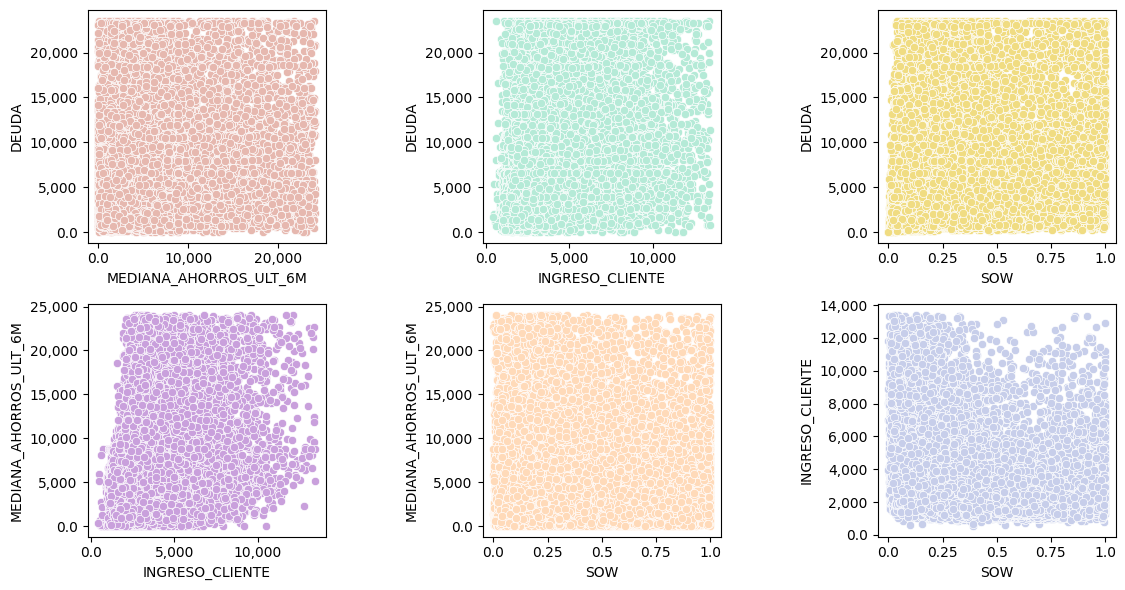

In [15]:
# create combinations
combinations = list(combi(selected_numeric_features, 2))

# declare combination colors
colors = ["#E6B8AF", "#B5EAD7", "#F0DC82", "#C9A0DC", "#FFDAB9", "#C7CEEA"]

# declare plot
fig, axis = plt.subplots(2, 3, figsize = (12, 6))

# plot combinations on scatter plot
for n_iter, (feature_1, feature_2) in enumerate(combinations):
    # declaring axis
    row = n_iter // 3
    col = n_iter % 3
    ax = axis[row][col]

    # removing outliers to visualize correctly
    temp = num_data[(num_data[feature_1] < num_data[feature_1].quantile(0.99)) &
                    (num_data[feature_2] < num_data[feature_2].quantile(0.99))].copy()
    
    # plotting scatterplot
    sns.scatterplot(data = temp,
                    y = feature_1,
                    x = feature_2,
                    color = colors[n_iter],
                    ax = ax)
    
    # set right separator
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',') if x > 1000 else str((x))))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',') if x > 1000 else str((x))))
plt.tight_layout()
plt.show()


<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* With this 2D plot we cannot determine the proper cutoffs because it is more likely for the groups to be in a higher space we are not able to reach (at most 3D).
* We can infer that removing outliers for visualization has left only a small group limited by its threshold, which also reveals the existence of a big cluster in tearms of amount of money.
* It would be naive to arrive at a conclusion with only this 2D approach, at least we can answer the subquestion.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

No! We need to access to a higher visualization to observe if clusters can be detected easily.

2D Scatterplots does not show if there are high dimensional groups. Even if we would like to access to that hyperplane it'd be impossible. Nevertheless, there are methods that preserve those high groups and can put them on a 2D scatterplot: UMAP. This comes with the following question:

<span style="color:#B0E57C; font-weight:bold;">02. Can we determine the right cutoffs by plotting them on a 2D scatter plot coming from a higher dimensional space?</span>

To answer, we need to create a umap instance fed by the four selected features. In addition, this object expects for the input to be cleaned, this means it has to be with no null values. We impute them by replacing their nan values with 0 because we cannot infer neither their debt nor liabilities nor credits. If we imputed them with aggregation metrics like mean or median, we would be assigning them an amount that does not correspond to theirs.

In [16]:
# select data for training reducer
groups = num_data[selected_numeric_features].copy()

# declare instances for imputing and reducing dimensionality
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
reducer = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.25, random_state = 123)

# put them into a pipeline
reducer_pipe = make_pipeline(imputer, reducer)

# fit reducing pipeline
reducer_pipe.fit(groups)

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('umap',
                 UMAP(min_dist=0.25, n_jobs=1, n_neighbors=30, random_state=123, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

As we have reduced the four-dimensional-space to a two-dimensional one, we cant plot the transformed features on a scatterplot to observe the existence of high dimensional groups.

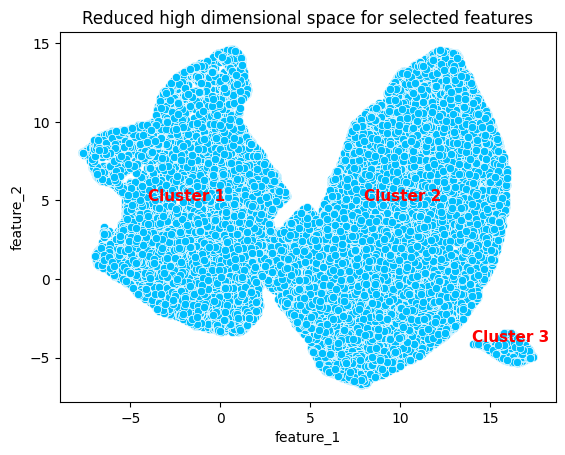

In [17]:
# create dataframe for reduced features
reduced_features = pd.DataFrame(reducer_pipe.transform(groups), columns = ['feature_1', 'feature_2'])

# plot them on a scatterplot
sns.scatterplot(data = reduced_features,
                x = 'feature_1',
                y = 'feature_2',
                color = 'deepskyblue')
# add title
plt.title('Reduced high dimensional space for selected features')

# create position text
text_pos = [(-4, 5), (8, 5), (14, -4)]
text_val = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# write text
for cluster_name, (x_pos, y_pos) in zip(text_val, text_pos):
    plt.text(x = x_pos,
             y = y_pos,
             s = cluster_name,
             color = 'red',
             weight = 'bold',
             fontsize = 11)

plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* It can be noticed some groups from the high dimensional space. This creates the posibility of segmentation and validates our selected features to start opening the universe.
* It would be sensible to choose 3 cluster because they are the ones that can be seen, however, it would be more accurate to select them with a correct metric.
* The selected features clearly open the universe correctly, just by analyzing the scatterplot we observe consistent cluster.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

No again! But we have seen the existence of groups on a higher dimensional space. This will be useful to create the cutoffs.

We can confirm that the universe can be segmented by looking a the reduced scatterplot. We can start with 3 clusters as the pic shows it, nonetheless, we need to measure how good is the cluster with a metric. This is the start point for the following big question, that also will help to finally respond this one regarding the right cutoffs.

# <span style="color:#FF6600; font-weight:bold;">Third Question:</span> <span style="color:#6699CC;">How many clusters are we supposed to aim in order to make the evaluation sustainable?</span>


We start by saying that having a chosen number of clusters has nothing to do with the business' purposes. This occurs because there are some rules that need to be accomplished. For instance, normally the companies work with a single machine learning model for their universe, having a ML model for each cluster would represent so much management on it, which also comes with more people to control them. So, in this section, we determine the right number of groups with numeric metrics and with business analysis, this arrives at the following question:

<span style="color:#B0E57C; font-weight:bold;">01. How many clusters can we detect numerically?</span>

In [18]:
# select data for training reducer
groups = num_data[selected_numeric_features].copy()

# declare instances for imputing and reducing dimensionality
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
scaler = StandardScaler()

# create preprocessing pipeline
preprocessing = make_pipeline(imputer, scaler)

# create a copy of reduced_features to store clusters
reduced_features_cluster = reduced_features.copy()

# save prediction metric
metrics = list()

# iterate with the number of clusters for two algorithms
for n_clusters in range(2, 8):
    # display current clusters
    print(f'{bcolors.BOLD_BLUE}Fitting for n_clusters = {n_clusters}{bcolors.ENDC}')
    # declare unsupervised models
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', algorithm = 'elkan', random_state = 123)
    gaussian = GaussianMixture(n_components = n_clusters, max_iter = 300, covariance_type = 'diag', init_params = 'k-means++', random_state = 123)

    # put them into a pipeline
    kmeans_pipe = make_pipeline(preprocessing, kmeans)
    gaussian_pipe = make_pipeline(preprocessing, gaussian)

    # fit pipelines
    print(f'\t{bcolors.BOLD_MAGENTA}Fitting KMeans ...{bcolors.ENDC}')
    kmeans_pipe.fit(groups)
    print(f'\t{bcolors.BOLD_RED}Fitting Gaussian Mixture Model ...{bcolors.ENDC}')
    gaussian_pipe.fit(groups)

    # save predictions
    reduced_features_cluster[f'kmeans_label_{n_clusters}'] = kmeans_pipe.predict(groups)
    reduced_features_cluster[f'gaussian_label_{n_clusters}'] = gaussian_pipe.predict(groups)

    # save metrics
    print(f'\t{bcolors.BOLD_MAGENTA}Saving KMeans metrics ...{bcolors.ENDC}')
    metrics.append({'algorithm': 'kmeans',
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette_score(preprocessing.transform(groups),
                                                         reduced_features_cluster[f'kmeans_label_{n_clusters}'])})
    print(f'\t{bcolors.BOLD_RED}Saving Gaussian metrics ...{bcolors.ENDC}\n')
    metrics.append({'algorithm': 'gaussian',
                    'n_clusters': n_clusters,
                    'silhouette_score': silhouette_score(preprocessing.transform(groups),
                                                         reduced_features_cluster[f'gaussian_label_{n_clusters}'])})

# saving dataframe
metrics = pd.DataFrame(metrics)\
            .sort_values(by = ['algorithm', 'n_clusters'], 
                         ascending = [False, True],
                         ignore_index = True)

Fitting for n_clusters = 2
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...

Fitting for n_clusters = 3
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...

Fitting for n_clusters = 4
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...

Fitting for n_clusters = 5
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...

Fitting for n_clusters = 6
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...

Fitting for n_clusters = 7
	Fitting KMeans ...
	Fitting Gaussian Mixture Model ...
	Saving KMeans metrics ...
	Saving Gaussian metrics ...



To see how many clusters we need, we look for the highest score

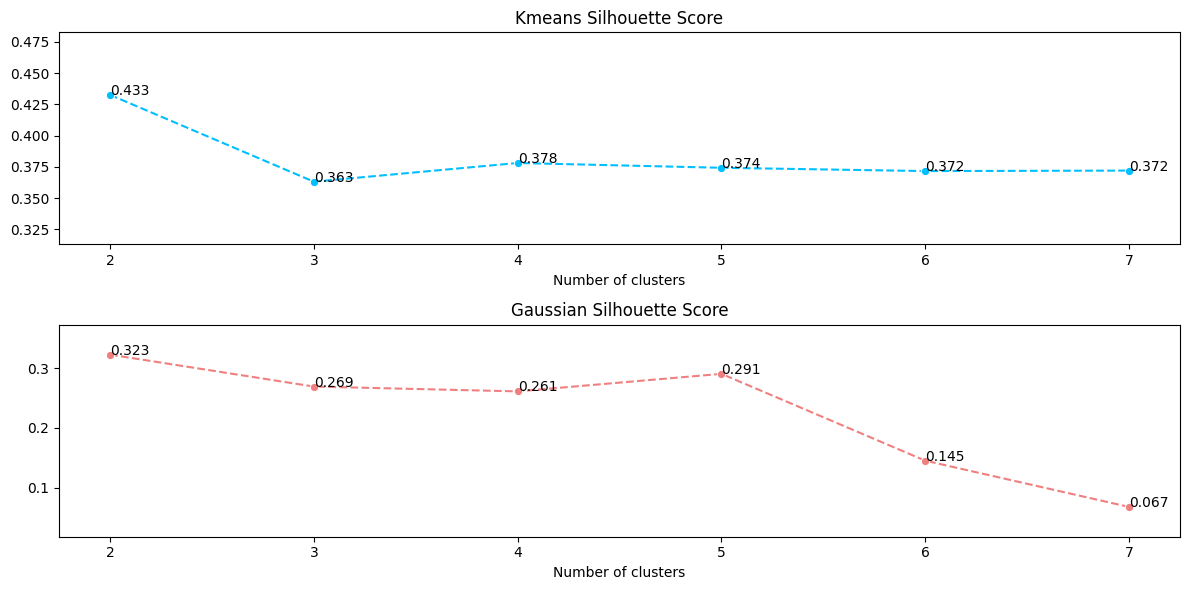

In [19]:
# get metrics along clusters
metrics_k = metrics.loc[metrics['algorithm'] == 'kmeans', 'silhouette_score']\
                   .to_numpy()

metrics_g = metrics.loc[metrics['algorithm'] == 'gaussian', 'silhouette_score']\
                   .to_numpy()
# set colors
colors = ['deepskyblue', 'lightcoral']

# declare figplot
fig, axis = plt.subplots(2, 1, figsize = (12, 6))

for n_iter,(algorithm, metric, color) in enumerate(zip(['kmeans', 'gaussian'], 
                                                [metrics_k, metrics_g],
                                                colors)):
    # set axis
    row = n_iter
    ax = axis[row]
    
    # plot lineplot
    sns.lineplot(x = np.arange(2, 8),
                 y = metric,
                 linestyle = 'dashed',
                 marker = 'o',
                 color = color, 
                 ax = ax)
    
    # set title
    ax.set_title(f'{algorithm.capitalize()} Silhouette Score')

    # set label title
    ax.set_xlabel(f'Number of clusters')

    # set limits
    ax.set_ylim(min(metric) - 0.05, max(metric) + 0.05)
    # set numbers
    for x_pos, y_pos in zip(np.arange(2, 8), metric):
        ax.text(x = x_pos,
                y = y_pos,
                s = f'{y_pos:.3f}')
    
plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* In terms of performance, we observe that both algorithms have their highest value when they are composed by two clusters, which also means the data is more cohesive. We could stay with two clusters but we cannot lose the business' track.
* Considering that between 0.25 and 0.5 clusters are considered acceptable with some overlapping, we should stay torn between either two or three clusters.
* It is important to select properly the number of clusters because this is the start modelling as many mondels as clusters we agree to have.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

The chosen clusters for this question would be either two or three of them.

According to metrics, we should decide at most three clusters, and being more specific, actually two because it has the highest score. Nevertheless, we are not supposed to ignore the business' aim which consists of seeing the identified groups clearly. This arrives at the following question:

<span style="color:#B0E57C; font-weight:bold;">02. How many clusters can we detect with business sense?</span>

It is important to visualize how the clusters behave in the reduced high dimensional space. This is actually the immediate answer, if the business can see the well-conformed groups, it will give it a go.

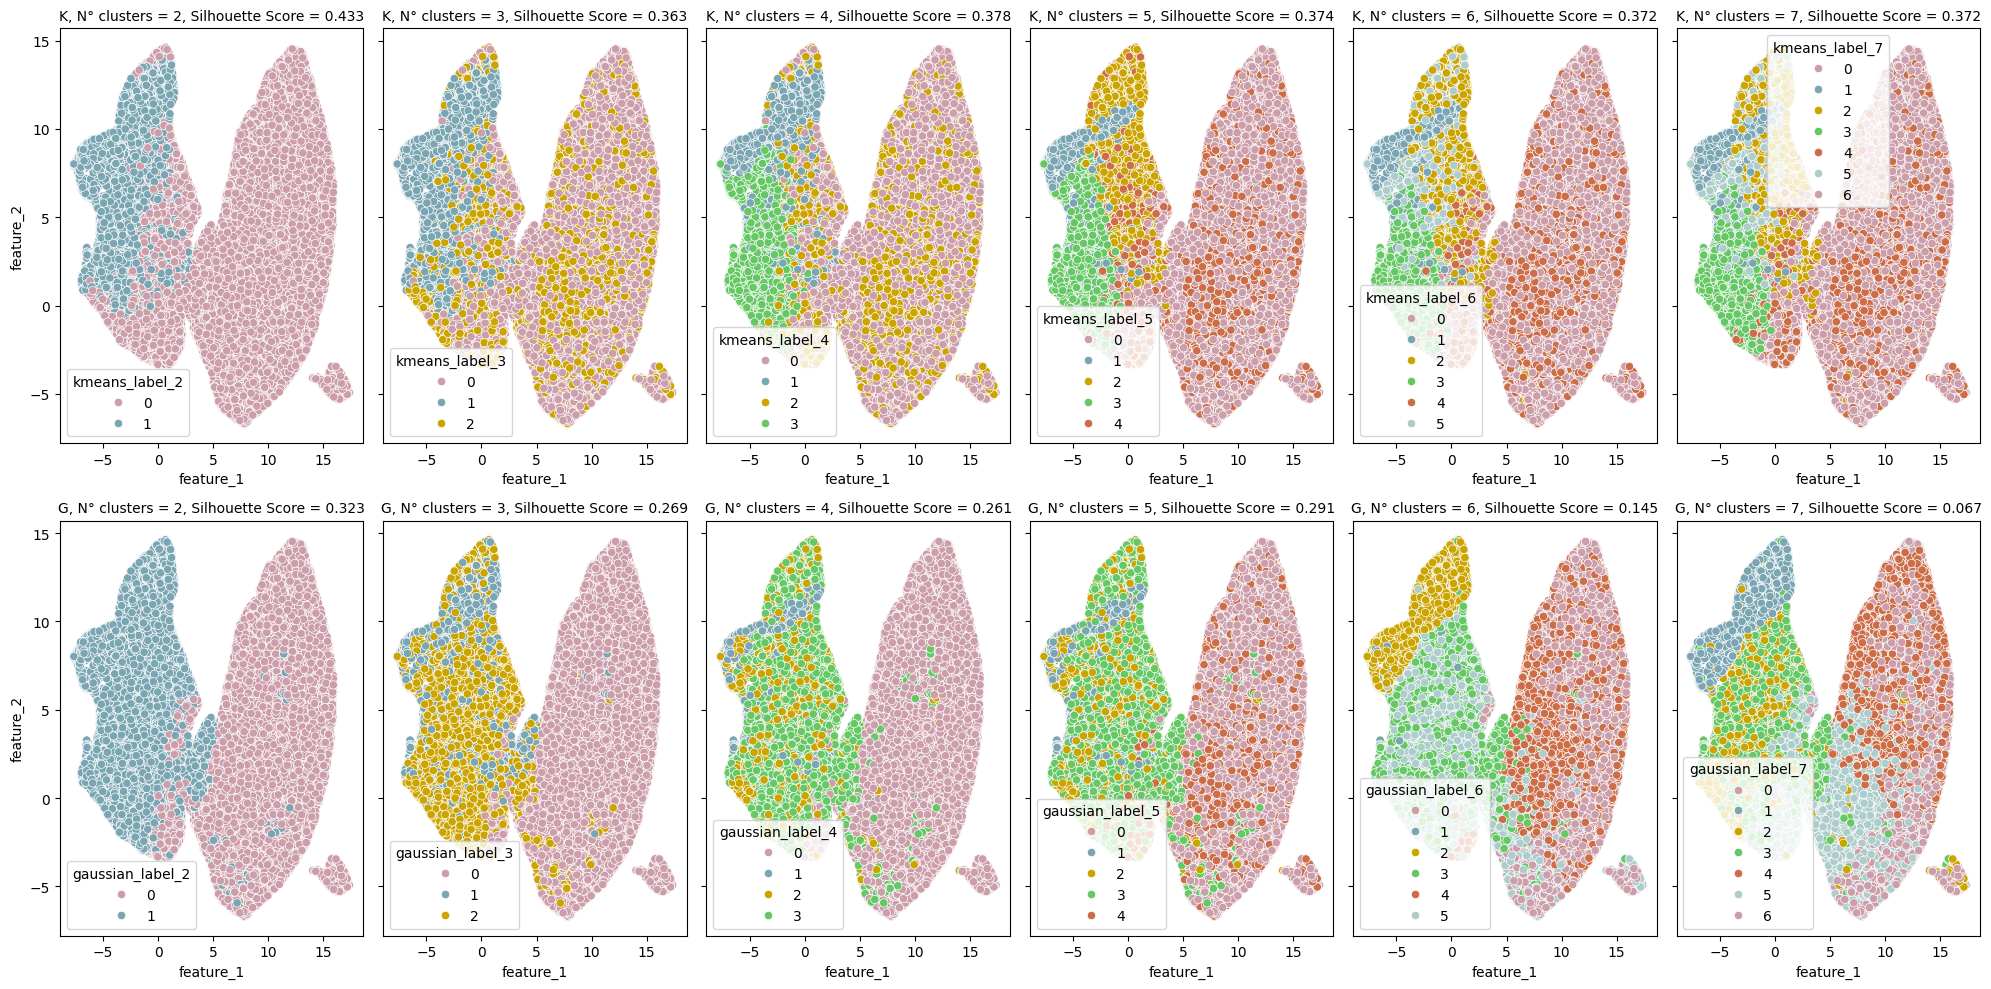

In [20]:
# declare colors
colors = ['#FFD1DC', '#ADD8E6', '#FFD700', '#98FB98', '#FFA07A', '#E0FFFF']

# darken colors
def darken_color(hex_color, factor = 0.5):
    rgb = mcolors.hex2color(hex_color)
    dark_rgb = [max(0, c - factor) for c in rgb]
    return mcolors.rgb2hex(dark_rgb)

colors = [darken_color(color, 0.2) for color in colors]

# declare subplots
fig, axis = plt.subplots(2, 6, figsize = (20, 10), sharey = True)

for n_iter, (color, n_clusters) in enumerate(zip(colors, range(2, 8))):
    # get axis
    col = n_iter
    ax_k = axis[0][col]
    ax_g = axis[1][col]

    # plot umap data on scatter plot
    sns.scatterplot(data = reduced_features_cluster,
                    x = 'feature_1',
                    y = 'feature_2',
                    hue = f'kmeans_label_{n_clusters}',
                    palette = colors[:n_clusters],
                    ax = ax_k)
    
    sns.scatterplot(data = reduced_features_cluster,
                    x = 'feature_1',
                    y = 'feature_2',
                    hue = f'gaussian_label_{n_clusters}',
                    palette = colors[:n_clusters],
                    ax = ax_g)
    
    # set metric as title
    sil_k = metrics.loc[(metrics['algorithm'] == 'kmeans') &
                        (metrics['n_clusters'] == n_clusters), 'silhouette_score']\
                   .values[0]
    
    sil_g = metrics.loc[(metrics['algorithm'] == 'gaussian') &
                        (metrics['n_clusters'] == n_clusters), 'silhouette_score']\
                   .values[0]
    
    ax_k.set_title(f'K, N° clusters = {n_clusters}, Silhouette Score = {sil_k:.3f}', 
                   fontdict = dict(fontsize = 10))
    ax_g.set_title(f'G, N° clusters = {n_clusters}, Silhouette Score = {sil_g:.3f}', 
                   fontdict = dict(fontsize = 10))

plt.tight_layout()
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* We may consider excluding cluster ranging from 4 to 6 because they do not seem to be neither well organized in groups nor have a good score.
* Regarding our conclusions from previous question, having three clusters also do not show consisted groups, we should stay with two clusters.
* Finally, considering the existence of two clusters, we could stay with kmeans algorithm because of its metric, however, gaussian algorithm provides a better grouping for consistence in terms of visualization, moreover, the shape of the groups look more cohesive.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

The chosen clusters for this question are two, being more specific, two gaussian clusters.

The answer for the big question is two gaussian clusters. With this information, we would finish to answer the second question. This is done by training a simple desicion tree classifier which target would be the gaussian clusters, then we get the cutoffs by accessing to the tree.

In [21]:
# create decision tree data
dt_data = pd.concat([num_data[selected_numeric_features], 
                     reduced_features_cluster[['gaussian_label_2']]], axis = 1)

# get X and y matrices
X = dt_data[selected_numeric_features]
y = dt_data['gaussian_label_2']

# create imputer
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)

# create dtc instance
dtc = DecisionTreeClassifier(max_depth = 4,
                             min_samples_split = 0.05,
                             class_weight = 'balanced',
                             random_state = 123)

# create pipeline
dtc_pipe = make_pipeline(imputer, dtc)

# fit pipeline
dtc_pipe.fit(X, y)

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                                        min_samples_split=0.05,
                                        random_state=123))])

This decision tree classifier needs to be transformed into a business one, this is achieved by pruning some of its branches or leaves. Let's look into the first outcome and then we will be rounding and selecting how it has to grow.

In [22]:
print(f'Accuracy: {dtc_pipe.score(X, y):.2%}')
print(export_text(dtc_pipe[-1], feature_names = selected_numeric_features))

Accuracy: 98.09%
|--- INGRESO_CLIENTE <= 2816.55
|   |--- DEUDA <= 9496.68
|   |   |--- MEDIANA_AHORROS_ULT_6M <= 11869.01
|   |   |   |--- INGRESO_CLIENTE <= 232.92
|   |   |   |   |--- class: 0
|   |   |   |--- INGRESO_CLIENTE >  232.92
|   |   |   |   |--- class: 0
|   |   |--- MEDIANA_AHORROS_ULT_6M >  11869.01
|   |   |   |--- class: 1
|   |--- DEUDA >  9496.68
|   |   |--- class: 1
|--- INGRESO_CLIENTE >  2816.55
|   |--- INGRESO_CLIENTE <= 3636.46
|   |   |--- MEDIANA_AHORROS_ULT_6M <= 9790.37
|   |   |   |--- DEUDA <= 7439.73
|   |   |   |   |--- class: 0
|   |   |   |--- DEUDA >  7439.73
|   |   |   |   |--- class: 1
|   |   |--- MEDIANA_AHORROS_ULT_6M >  9790.37
|   |   |   |--- class: 1
|   |--- INGRESO_CLIENTE >  3636.46
|   |   |--- INGRESO_CLIENTE <= 3898.94
|   |   |   |--- class: 1
|   |   |--- INGRESO_CLIENTE >  3898.94
|   |   |   |--- INGRESO_CLIENTE <= 3998.08
|   |   |   |   |--- class: 1
|   |   |   |--- INGRESO_CLIENTE >  3998.08
|   |   |   |   |--- class: 1



We need to sort the intervals, in other words, we need to group the cutoffs for each class:

* Class 0: (<span style="color:#E6B8AF">**income**</span> <= 2816.55) & (<span style="color:#B5EAD7">**debt**</span> <= 9496.68) & (<span style="color:#F0DC82">**liabilities**</span> <= 11869.01)
* Class 0: (2816.55 < <span style="color:#E6B8AF">**income**</span> <= 3636.46) & (<span style="color:#F0DC82">**liabilities**</span> <= 9790.37) & (<span style="color:#B5EAD7">**debt**</span> <= 7439.73)
&nbsp;<br>
&nbsp;<br>
* Class 1: (<span style="color:#E6B8AF">**income**</span> <= 2816.55) & (<span style="color:#B5EAD7">**debt**</span> <= 9496.68) & (<span style="color:#F0DC82">**liabilities**</span> > 11869.01)
* Class 1: (<span style="color:#E6B8AF">**income**</span> <= 2816.55) & (<span style="color:#B5EAD7">**debt**</span> > 9496.68)
* Class 1: (2816.55 < <span style="color:#E6B8AF">**income**</span> <= 3636.46) & (<span style="color:#F0DC82">**liabilities**</span> <= 9790.37) & (<span style="color:#B5EAD7">**debt**</span> > 7439.73)
* Class 1: (2816.55 < <span style="color:#E6B8AF">**income**</span> <= 3636.46) & (<span style="color:#F0DC82">**liabilities**</span> > 9790.37)
* Class 1: (<span style="color:#E6B8AF">**income**</span> > 3636.46)



We would like to start the segmentation with debt because the business needs to prioritize which cluster gives it more profitability, this can be measured by how much leverage the client is taking on. In addition, we have already analyzed that getting a big loan also comes with higher incomes.

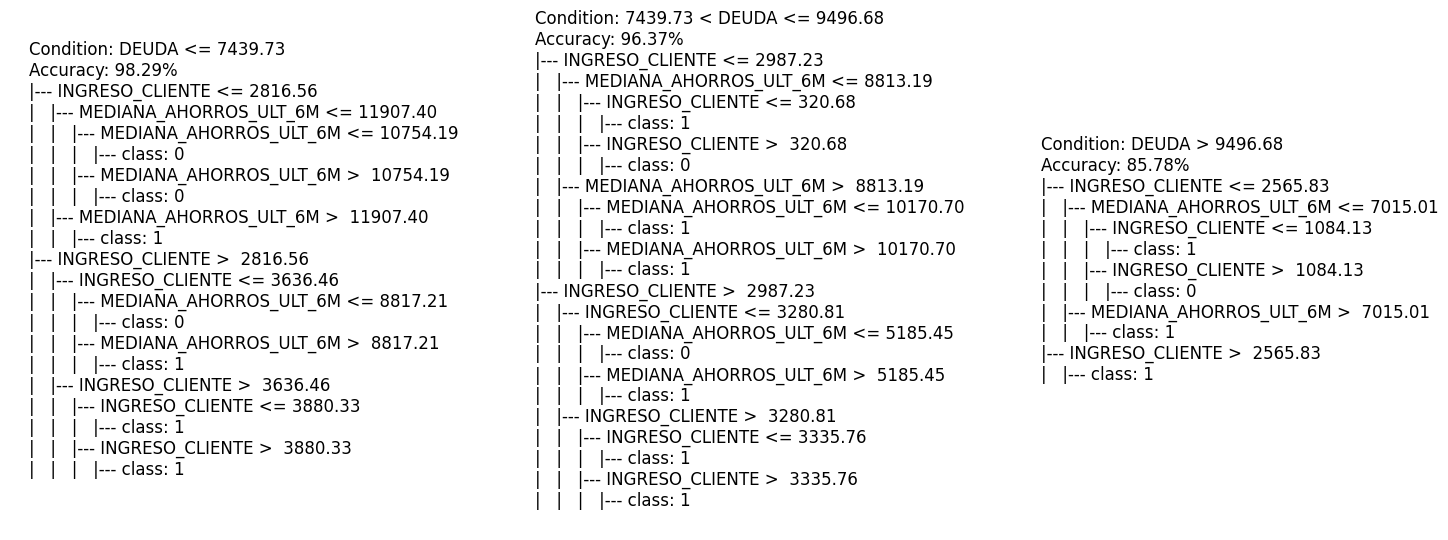

In [23]:
# create debt conditions
debt = 'DEUDA'
conditions = [lambda df: (df[debt] <= 7439.73),
              lambda df: (7439.73 < df[debt]) & (df[debt] <= 9496.68),
              lambda df: (9496.68 < df[debt])]

# condiciones en texto
text_conditions = [f'{debt} <= 7439.73',
                   f'7439.73 < {debt} <= 9496.68',
                   f'{debt} > 9496.68']

# declare dtc and pipeline
dtc = DecisionTreeClassifier(max_depth = 3,
                             min_samples_split = 0.05,
                             class_weight = 'balanced',
                             random_state = 123)

dtc_pipe = make_pipeline(imputer, dtc)
# Test conditions
fig, axis = plt.subplots(1, len(conditions), figsize=(15, 5))

for i, cond in enumerate(conditions):
    # Select subuniverse
    dt_data_temp = dt_data[cond(dt_data)].copy()

    # Split into matrices
    X = dt_data_temp[selected_numeric_features[1:]]
    y = dt_data_temp['gaussian_label_2']

    # Fit pipeline
    dtc_pipe.fit(X, y)

    # Get the tree as text
    tree_text = export_text(dtc_pipe[-1], feature_names = selected_numeric_features[1:])
    accuracy = dtc_pipe.score(X, y)

    # Display results
    axis[i].text(0.05, 0.05, f'Condition: {text_conditions[i]}\nAccuracy: {accuracy:.2%}\n{tree_text}',
                 ha = 'left', va = 'center', fontsize = 12)
    axis[i].axis('off')

plt.tight_layout()
plt.show()

Let's get the new cutoffs:

* <span style="color:#B5EAD7">**debt**</span> <= 7439.73
    * class 0: (<span style="color:#E6B8AF">**income**</span> <= 2816.56) & (<span style="color:#F0DC82">**liabilities**</span> <= 11907.40)
    * class 0: (2816.56 < <span style="color:#E6B8AF">**income**</span> <= 3636.46) & (<span style="color:#F0DC82">**liabilities**</span> <= 8817.21)
    &nbsp;<br>
    &nbsp;<br>
    * class 1: (<span style="color:#E6B8AF">**income**</span> <= 2816.56) & (<span style="color:#F0DC82">**liabilities**</span> > 11907.40)
    * class 1: (2816.56 < <span style="color:#E6B8AF">**income**</span> <= 3636.46) & (<span style="color:#F0DC82">**liabilities**</span> > 8817.21)
    * class 1: (<span style="color:#E6B8AF">**income**</span> > 3636.46)
&nbsp;<br>
&nbsp;<br>
* 7439.73 < <span style="color:#B5EAD7">**debt**</span> <= 9496.68
    * class 0: (320.68 < <span style="color:#E6B8AF">**income**</span> <= 2987.23) & (<span style="color:#F0DC82">**liabilities**</span> <= 8813.19)
    * class 0: (2987.23 < <span style="color:#E6B8AF">**income**</span> <= 3280.81) & (<span style="color:#F0DC82">**liabilities**</span> <= 5185.45)
    &nbsp;<br>
    &nbsp;<br>
    * class 1: (<span style="color:#E6B8AF">**income**</span> <= 320.68) & (<span style="color:#F0DC82">**liabilities**</span> <= 8813.19)
    * class 1: (<span style="color:#E6B8AF">**income**</span> <= 2987.23) & (<span style="color:#F0DC82">**liabilities**</span> > 8813.19)
    * class 1: (2987.23 < <span style="color:#E6B8AF">**income**</span> <= 3280.81) & (<span style="color:#F0DC82">**liabilities**</span> > 5185.45)
    * class 1: (3280.81 < <span style="color:#E6B8AF">**income**</span>)
&nbsp;<br>
&nbsp;<br>
* 9496.68 < <span style="color:#B5EAD7">**debt**</span>
    * class 0: (1084.13 < <span style="color:#E6B8AF">**income**</span> <= 2565.83) & (<span style="color:#F0DC82">**liabilities**</span> <= 7015.01)
    &nbsp;<br>
    &nbsp;<br>
    * class 1: (<span style="color:#E6B8AF">**income**</span> <= 1084.13) & (<span style="color:#F0DC82">**liabilities**</span> <= 7015.01)
    * class 1: (<span style="color:#E6B8AF">**income**</span> <= 2565.83) & (<span style="color:#F0DC82">**liabilities**</span> > 7015.01)
    * class 1: (<span style="color:#E6B8AF">**income**</span> > 2565.83)

We need to decide whether to split by liabilities or income, we have observed that debt vs liabilities has a better looking for a two-cluster distribution.

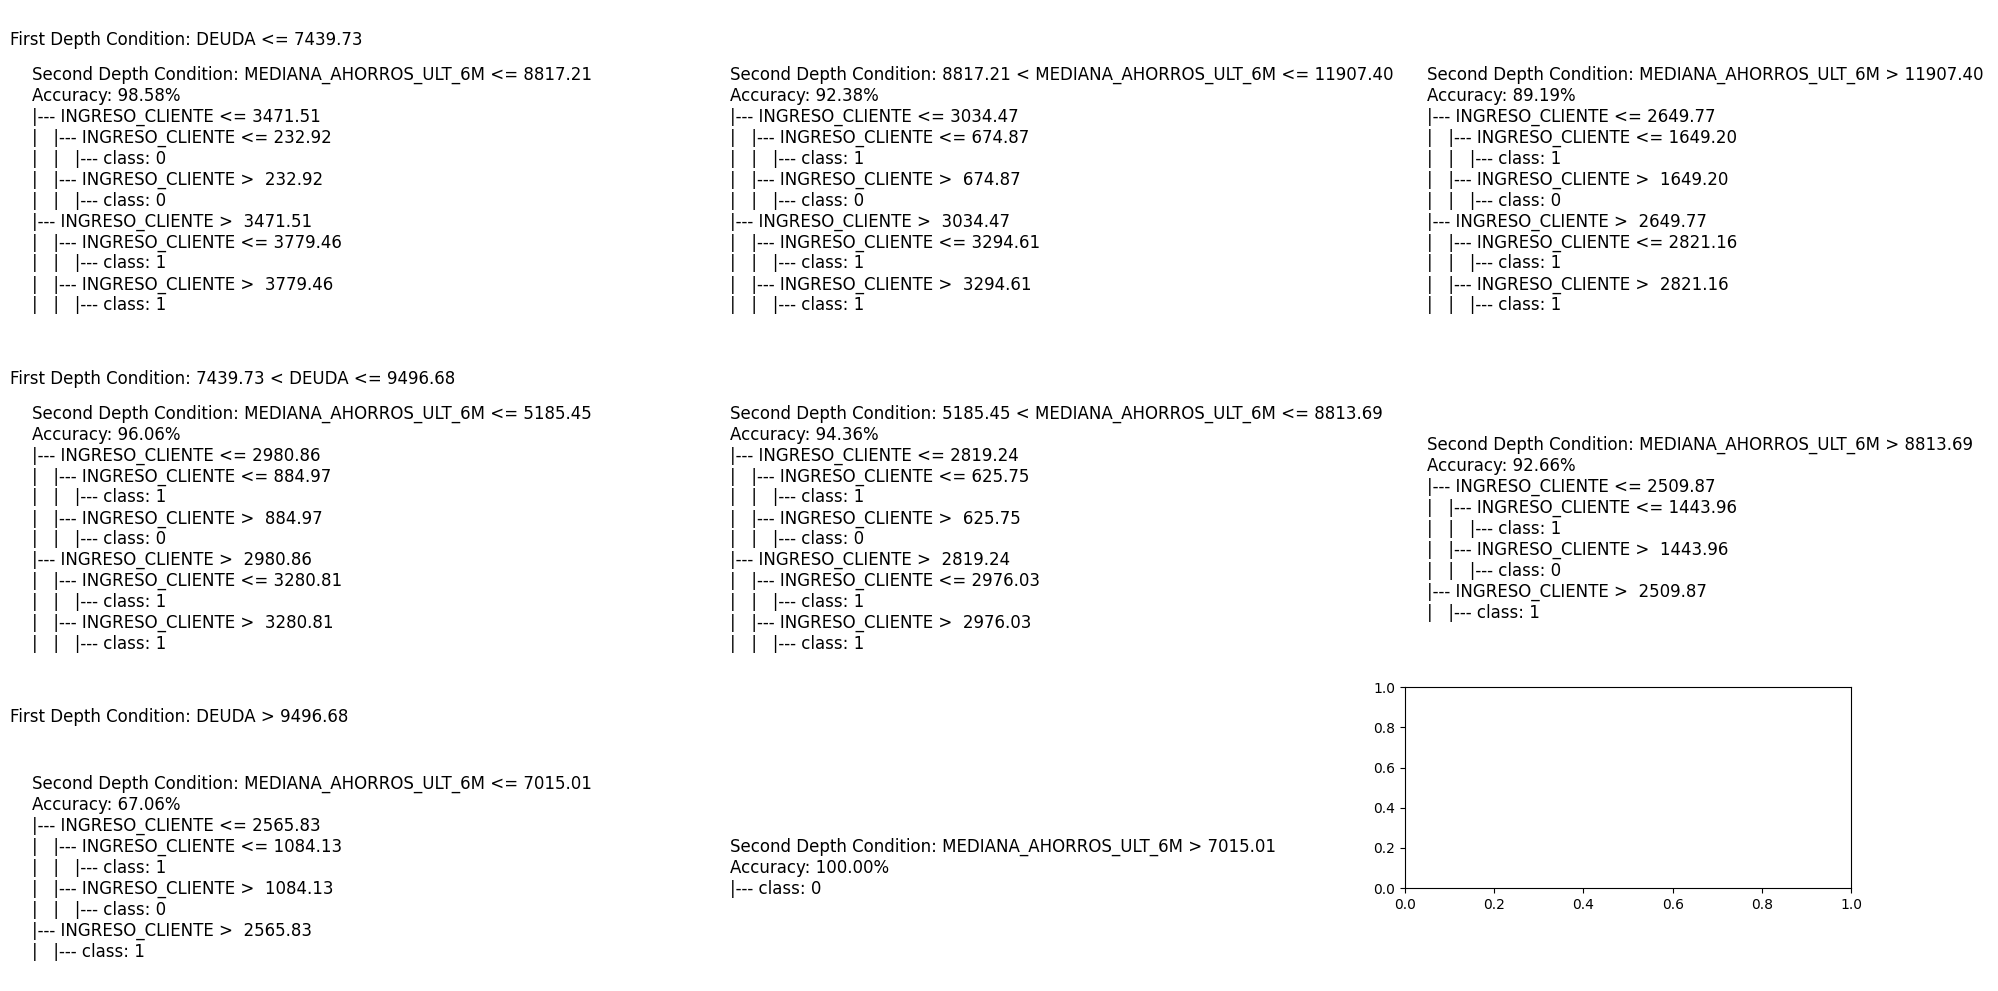

In [24]:
# create debt and liabilities conditions
debt = 'DEUDA'
debt_conditions = [lambda df: (df[debt] <= 7439.73),
                   lambda df: (7439.73 < df[debt]) & (df[debt] <= 9496.68),
                   lambda df: (9496.68 < df[debt])]

liabilities = 'MEDIANA_AHORROS_ULT_6M'
lia_conditions = {'cond_0': [lambda df: (df[liabilities] <= 8817.21),
                             lambda df: (8817.21 < df[liabilities]) & (df[liabilities] <= 11907.40),
                             lambda df: (11907.40 < df[liabilities])],

                  'cond_1': [lambda df: (df[liabilities] <= 5185.45),
                             lambda df: (5185.45 < df[liabilities]) & (df[liabilities] <= 8813.69),
                             lambda df: (8813.69 < df[liabilities])],
                             
                  'cond_2': [lambda df: (df[liabilities] <= 7015.01),
                             lambda df: (7015.01 < df[liabilities])]}

# create conditions for debt based on liablities
debt_lia_cond = ['cond_0', 'cond_1', 'cond_2']
# condiciones en texto
text_debt_conditions = [f'{debt} <= 7439.73',
                        f'7439.73 < {debt} <= 9496.68',
                        f'{debt} > 9496.68']

text_lia_conditions = {'cond_0': [f'{liabilities} <= 8817.21',
                                  f'8817.21 < {liabilities} <= 11907.40 ',
                                  f'{liabilities} > 11907.40 '],

                       'cond_1': [f'{liabilities} <= 5185.45',
                                  f'5185.45 < {liabilities} <= 8813.69 ',
                                  f'{liabilities} > 8813.69 '],

                       'cond_2': [f'{liabilities} <= 7015.01',
                                  f'{liabilities} > 7015.01 ']}

# declare dtc and pipeline
dtc = DecisionTreeClassifier(max_depth = 2,
                             min_samples_split = 0.05,
                             class_weight = 'balanced',
                             random_state = 123)

dtc_pipe = make_pipeline(imputer, dtc)

# create base plot
fig, axis = plt.subplots(3, len(conditions), figsize = (20, 10))

# iterate over debt and liabilities conditions
for i, (debt_cond, lia_cond) in enumerate(zip(debt_conditions, debt_lia_cond)):
    # get current liabilities conditions
    lia_cond_temp = lia_conditions[lia_cond]
    axis[i][0].text(0, 0.8, f'First Depth Condition: {text_debt_conditions[i]}\n',
                    ha = 'left', va = 'center', fontsize = 12)
    # iterate over temp conditions 
    for j, lia in enumerate(lia_cond_temp):
        # Select subuniverse
        dt_data_temp = dt_data[debt_cond(dt_data) & lia(dt_data)].copy()

        # Split into matrices
        X = dt_data_temp[selected_numeric_features[2:]]
        y = dt_data_temp['gaussian_label_2']

        # Fit pipeline
        dtc_pipe.fit(X, y)

        # Get the tree as text
        tree_text = export_text(dtc_pipe[-1], feature_names = selected_numeric_features[2:])
        accuracy = dtc_pipe.score(X, y)

        # Display results
        axis[i][j].text(0.05, 0.05, f'Second Depth Condition: {text_lia_conditions[lia_cond][j]}\nAccuracy: {accuracy:.2%}\n{tree_text}',
                    ha = 'left', va = 'center', fontsize = 12)
        axis[i][j].axis('off')

plt.tight_layout()
plt.show()

* <span style="color:#B5EAD7">**debt**</span> <= 7439.73
    * <span style="color:#F0DC82">**liabilities**</span> <= 8817.21
        * class 0: (<span style="color:#E6B8AF">**income**</span> <= 3471.51) [<span style="color:cyan">**node 01**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 3471.51) [<span style="color:cyan">**node 02**</span>]
        &nbsp;<br>
        &nbsp;<br>  
    * 8817.21 < <span style="color:#F0DC82">**liabilities**</span> <= 11907.40
        * class 0: (674.87 < <span style="color:#E6B8AF">**income**</span> <= 3034.47) [<span style="color:cyan">**node 03**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 674.87) [<span style="color:cyan">**node 04**</span>]
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 3034.47) [<span style="color:cyan">**node 05**</span>]
        &nbsp;<br>
        &nbsp;<br>
    * 11907.40 < <span style="color:#F0DC82">**liabilities**</span>
        * class 0: (1649.20 < <span style="color:#E6B8AF">**income**</span> <= 2649.77) [<span style="color:cyan">**node 06**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 1649.20) [<span style="color:cyan">**node 07**</span>]
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 2649.77) [<span style="color:cyan">**node 08**</span>]
        &nbsp;<br>
        &nbsp;<br>

* 7439.73 < <span style="color:#B5EAD7">**debt**</span> <= 9496.68
    * <span style="color:#F0DC82">**liabilities**</span> <= 5185.45
        * class 0: (884.97 < <span style="color:#E6B8AF">**income**</span> <= 2980.86) [<span style="color:cyan">**node 09**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 884.97) [<span style="color:cyan">**node 10**</span>]
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 2980.86) [<span style="color:cyan">**node 11**</span>]
        &nbsp;<br>
        &nbsp;<br>
    * 5185.45 < <span style="color:#F0DC82">**liabilities**</span> <= 8813.69
        * class 0: (625.75 < <span style="color:#E6B8AF">**income**</span> <= 2819.24) [<span style="color:cyan">**node 12**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 625.75) [<span style="color:cyan">**node 13**</span>]
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 2819.24) [<span style="color:cyan">**node 14**</span>]
        &nbsp;<br>
        &nbsp;<br>
    * 8813.69 < <span style="color:#F0DC82">**liabilities**</span>
        * class 0: (1443.96 < <span style="color:#E6B8AF">**income**</span> <= 2649.77) [<span style="color:cyan">**node 15**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 1443.96) [<span style="color:cyan">**node 16**</span>] 
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 2649.77) [<span style="color:cyan">**node 17**</span>]
        &nbsp;<br>
        &nbsp;<br>

* 9496.68 < <span style="color:#B5EAD7">**debt**</span>
    * <span style="color:#F0DC82">**liabilities**</span> <= 7015.01
        * class 0: (1084.13 < <span style="color:#E6B8AF">**income**</span> <= 2565.83) [<span style="color:cyan">**node 18**</span>]
        &nbsp;<br>
        &nbsp;<br>
        * class 1: (<span style="color:#E6B8AF">**income**</span> <= 1084.13) [<span style="color:cyan">**node 19**</span>]
        * class 1: (<span style="color:#E6B8AF">**income**</span> > 2565.83) [<span style="color:cyan">**node 20**</span>]
        &nbsp;<br>
        &nbsp;<br>
    * <span style="color:#F0DC82">**liabilities**</span> > 7015.01
        * class 0: [<span style="color:cyan">**node 21**</span>]


After rounding some cutoffs and putting all together into a class, we have defined "BusinessDecisionTreeClassifier", which segments our univers in two groups, which will be analyzed. We have two clusters so far, let's verify the aggregation metrics to give the final answer to the subquestion

In [25]:
# declare custom decision tree classifier
bdt = BusinessDecisionTreeClassifier(get_nodes = True,
                                     debt_name = 'DEUDA',
                                     liabilities_name = 'MEDIANA_AHORROS_ULT_6M',
                                     income_name = 'INGRESO_CLIENTE',
                                     cluster_name = 'CLUSTER',
                                     node_name = 'NODE',
                                     rare_cluster = 999,
                                     rare_node = 999)

# selected necessary features for splitting
features = selected_numeric_features[:-1]

# preprocess only for segmentation
data_cal = pd.DataFrame(imputer.fit_transform(num_data[features]),
                        columns = features)

# include clusters
num_data[['NODE', 'CLUSTER']] = bdt.transform(data_cal)[['NODE', 'CLUSTER']]

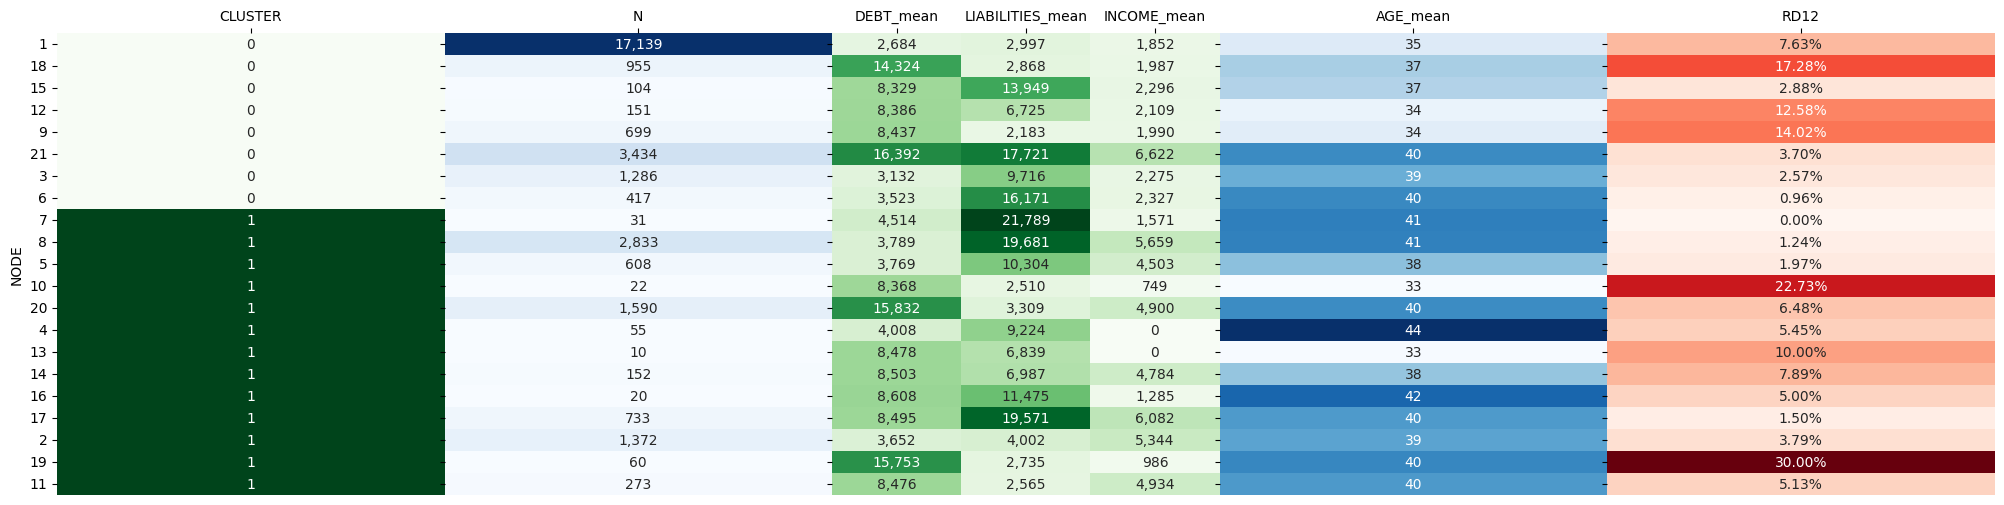

In [26]:
# get nodes and clusters
cluster_dict = dict(num_data[['NODE', 'CLUSTER']].drop_duplicates()\
                                            .to_dict('split')['data'])
# get aggregation metrics
summary = num_data.groupby('NODE')\
                  .agg({'CODSOLICITUD': 'count',
                        'DEUDA': 'mean',
                        'MEDIANA_AHORROS_ULT_6M': 'mean',
                        'INGRESO_CLIENTE': 'mean',
                        'EDAD_T': 'mean',
                        'FLG_DEFAULT_12M': 'mean'})\
                  .rename(columns = {'CODSOLICITUD': 'N',
                                     'DEUDA': 'DEBT_mean',
                                     'MEDIANA_AHORROS_ULT_6M': 'LIABILITIES_mean',
                                     'INGRESO_CLIENTE': 'INCOME_mean',
                                     'EDAD_T': 'AGE_mean',
                                     'FLG_DEFAULT_12M': 'RD12'})\
                  .fillna(0)

summary.insert(loc = 0,
               column = 'CLUSTER',
               value = summary.reset_index()['NODE'].map(cluster_dict).tolist())

summary.sort_values(by = ['CLUSTER'], ascending = True, inplace = True)

# declare groups of columns and their color maps
cmaps = [(['CLUSTER'], 'Greens'),
         (['N'], 'Blues'),
         (['DEBT_mean', 'LIABILITIES_mean', 'INCOME_mean'], 'Greens'),
         (['AGE_mean'], 'Blues'),
         (['RD12'], 'Reds')]


# create subplots
num_filas = len(cmaps) // 2
fig, axis = plt.subplots(1, 5, sharey= True, figsize = (25, 6))

# iterate over columns and cmaps
for idx, (columns, cmap) in enumerate(cmaps):
    ax = axis[idx]
    
    if 'RD12' not in columns:
        sns.heatmap(data = summary[columns], 
                    annot = True, 
                    cmap = cmap, 
                    fmt = ',.0f', 
                    cbar = False,
                    ax = ax)
        
    else:
        sns.heatmap(data = summary[columns], 
                    annot = True, 
                    cmap = cmap, 
                    fmt = '.2%', 
                    cbar = False,
                    ax = ax)
        
    ax.tick_params(axis ='x', rotation = 0)
    ax.tick_params(axis ='y', rotation = 0)

    # set the position of x-axis labels to top
    ax.xaxis.set_ticks_position('top')
    
    # show y-label only in the first subplot
    if idx == 0:
        ax.set_ylabel('NODE')
    else:
        ax.set_ylabel('')

# Adjust the margins between subplots
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()

It can be observed the clusters need to be reformulated cause they are not following rules regarding N and RD12, for example, a cluster with 30% can't be joined another with 6.48%, based on their aggregation metrics and RD12, we create another decision tree classifier, this time we change the cluster names for ones that are closer to the business: PEAK, representing the top cluster and CORPUS, representing the generic cluster.

In [27]:
# declare custom decision tree classifier
fbdt = FixedBusinessDecisionTreeClassifier(get_nodes = False,
                                           debt_name = 'DEUDA',
                                           liabilities_name = 'MEDIANA_AHORROS_ULT_6M',
                                           income_name = 'INGRESO_CLIENTE',
                                           cluster_name = 'FIXED_CLUSTER',
                                           node_name = 'NODE',
                                           rare_cluster = 999,
                                           rare_node = 999)

# selected necessary features for splitting
features = selected_numeric_features[:-1]

# preprocess only for segmentation
data_cal = pd.DataFrame(imputer.fit_transform(num_data[features]),
                        columns = features)

# include clusters
num_data['FIXED_CLUSTER'] = fbdt.transform(data_cal)['FIXED_CLUSTER']

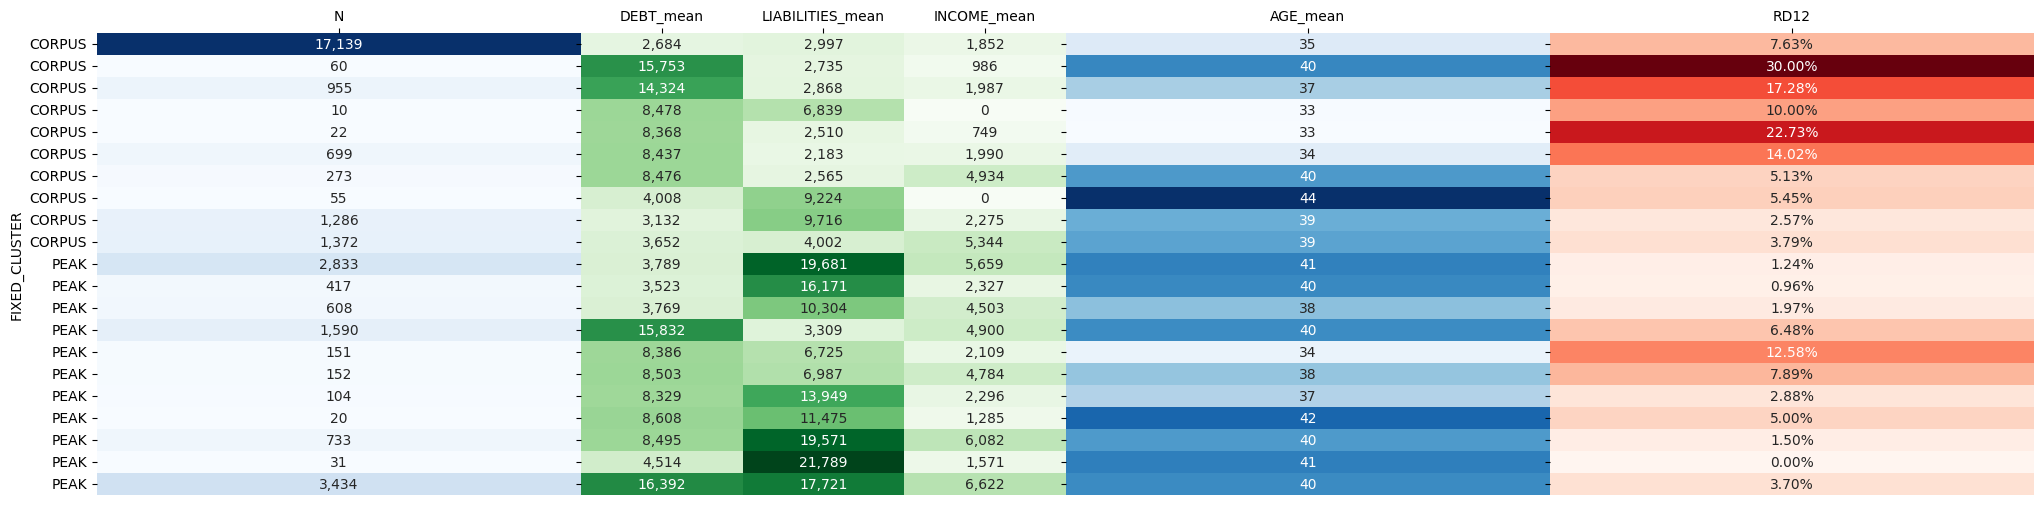

In [58]:
# get nodes and clusters
cluster_dict = dict(num_data[['NODE', 'FIXED_CLUSTER']].drop_duplicates()\
                                                       .to_dict('split')['data'])
# get aggregation metrics
summary = num_data.groupby('NODE')\
                  .agg({'CODSOLICITUD': 'count',
                        'DEUDA': 'mean',
                        'MEDIANA_AHORROS_ULT_6M': 'mean',
                        'INGRESO_CLIENTE': 'mean',
                        'EDAD_T': 'mean',
                        'FLG_DEFAULT_12M': 'mean'})\
                  .rename(columns = {'CODSOLICITUD': 'N',
                                     'DEUDA': 'DEBT_mean',
                                     'MEDIANA_AHORROS_ULT_6M': 'LIABILITIES_mean',
                                     'INGRESO_CLIENTE': 'INCOME_mean',
                                     'EDAD_T': 'AGE_mean',
                                     'FLG_DEFAULT_12M': 'RD12'})\
                  .fillna(0)

summary.insert(loc = 0,
               column = 'FIXED_CLUSTER',
               value = summary.reset_index()['NODE'].map(cluster_dict).tolist())

summary.sort_values(by = ['FIXED_CLUSTER'], ascending = True, inplace = True)

summary.set_index('FIXED_CLUSTER', inplace = True)
# declare groups of columns and their color maps
cmaps = [(['N'], 'Blues'),
         (['DEBT_mean', 'LIABILITIES_mean', 'INCOME_mean'], 'Greens'),
         (['AGE_mean'], 'Blues'),
         (['RD12'], 'Reds')]


# create subplots
num_filas = len(cmaps) // 2
fig, axis = plt.subplots(1, 4, sharey= True, figsize = (25, 6))

# iterate over columns and cmaps
for idx, (columns, cmap) in enumerate(cmaps):
    ax = axis[idx]
    
    if 'RD12' in columns:
        sns.heatmap(data = summary[columns], 
                    annot = True, 
                    cmap = cmap, 
                    fmt = '.2%', 
                    cbar = False,
                    ax = ax)
    
    else:
        sns.heatmap(data = summary[columns], 
                    annot = True, 
                    cmap = cmap, 
                    fmt = ',.0f', 
                    cbar = False,
                    ax = ax)
        
    ax.tick_params(axis ='x', rotation = 0)
    ax.tick_params(axis ='y', rotation = 0)

    # set the position of x-axis labels to top
    ax.xaxis.set_ticks_position('top')
    
    # show y-label only in the first subplot
    if idx == 0:
        ax.set_ylabel('FIXED_CLUSTER')
    else:
        ax.set_ylabel('')

# Adjust the margins between subplots
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()

<span style="color:#D8B0E5; font-weight:bold;">Observations:</span>

* We have sorted the clusters in a different way they were generated, this new distribution shows the universe more reliable regarding the one was split only by original decision tree classifier.
* To conclude this segmentation section, we have finally arrived at the right cutoffs for the universe. These ones are represented by the fixed clusters PEAK and CORPUS. This new punctuation is saved on another dataframe which will be used to answer the two left questions.

<span style="color:lightcoral; font-weight:bold;">Answer:</span>

Yes! We have found out how to split our population and then we are developing models two compare how good or bad could be this clusterization.

As we say, we need to punctuate the universe in order to get the encountered clusters.

In [60]:
# punctuate universe 
# declare custom decision tree classifier
fbdt = FixedBusinessDecisionTreeClassifier(get_nodes = False,
                                           debt_name = 'DEUDA',
                                           liabilities_name = 'MEDIANA_AHORROS_ULT_6M',
                                           income_name = 'INGRESO_CLIENTE',
                                           cluster_name = 'FIXED_CLUSTER',
                                           node_name = 'NODE',
                                           rare_cluster = 'RARE',
                                           rare_node = 999)

# selected necessary features for splitting
features = selected_numeric_features[:-1]

# preprocess only for segmentation
data_cal = pd.DataFrame(imputer.fit_transform(data[features]),
                        columns = features)

# include clusters
data['FIXED_CLUSTER'] = fbdt.transform(data_cal)['FIXED_CLUSTER']

Save segmented universe

In [62]:
data.to_csv('datasets/segmented_universe.csv', index = False)


# <span style="color:lightcoral; font-weight:bold;">SEGMENTATION CONCLUSIONS:</span> 


* It was important to identify what features we needed to split the universe and which of the rest were useful to validate it as well. In this scenario, we could appreciate that the created feature "SOW" was not relevant for the base decision tree classifier.

* The univariate analysis was helpful to understand how the features behaved regarding its distribution, this was like a first approach to find cutoffs for segmentation.

* The bivariate analysis was even more useful because we could see how the selected feautures behaved against other. In addition, having an aggregate metric per box help us visualize the existence of two cluster just by this 2D analysis.

* The multivariate analysis was incredibly explainable when it came to accessing to a high-dimensional space. When we observed three clusters we were not far away from the calculated ones.

* Finally, the combination of these three analysis and the explainability coming from a decision tree classifier arrived at getting the expected segmentation, validating metrics and replacing some of them with business criteria reenforced the cutoffs sense.